# Introduction

Predict Future Sales: The final project for "How to win a data science competition" Coursera course, part 2 of the advanced machine learning specialization. The goal is to predict the monthly sales of items in each shop for the month of Novemeber. There are 33 months of daily item-shop data given in the training dataset.

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [216]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
sns.set(style="darkgrid")


import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\items.csv
data\item_categories.csv
data\sales_train.csv
data\sample_submission.csv
data\shops.csv
data\test.csv


# Load Data

In [217]:


# load data
items=pd.read_csv("data/items.csv")
shops=pd.read_csv("data/shops.csv")
item_categories=pd.read_csv("data/item_categories.csv")
train=pd.read_csv("data/sales_train.csv")
test=pd.read_csv("data/test.csv")

# 1. Data Cleaning

We'll remove outliers, clean up some of the raw data and add some new variables to it.

# Remove outliers

<AxesSubplot:xlabel='item_price'>

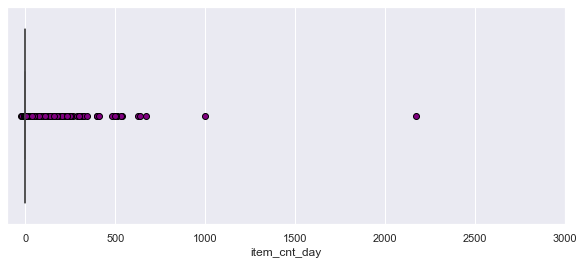

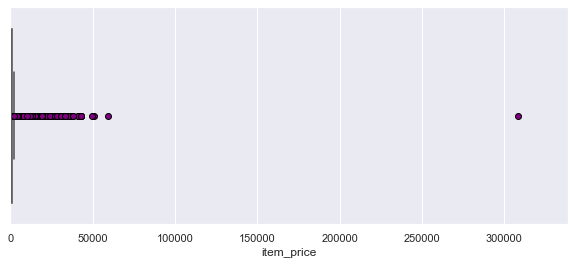

In [218]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

We'll remove the obvious outliers in the dataset - the items that sold more than 1000 in one day and the item with price greater than 300,000.

In [219]:
#lowest prices
# train.sort_values(['item_price']).head(n=10)

In [220]:
# train.sort_values(['item_price']).tail(n=10)

In [221]:
# train.sort_values(['item_cnt_day']).head(n=10)

In [222]:
# train.sort_values(['item_cnt_day']).tail(n=10)

# Large Price, Item Count Outlier

This item id only has 1 record. It will be removed from the dataset.

In [223]:
# train[train['item_id'] == 6066]

In [224]:
train.drop(1163158,axis=0,inplace=True)
train.reset_index(drop=True,inplace=True)

# Negative Prices

The negative price will be replaced by the median value for the item id, shop id, and date block number.

In [225]:
# train[train['item_id'] == 2973].sort_values('item_price').head(n=5)

In [226]:
# train.loc[484683,'item_price'] = train[(train['item_id'] == 2973) \
#                                                & (train['shop_id'] == 32) \
#                                                & (train['date_block_num'] == 4)]['item_price'].median()

# High Item Count Day Outlier

Replace with the median price and item count for item id, shop id, and date block number.

In [227]:
# train[(train.item_id == 11373)&(train.date_block_num==33)].sort_values('item_cnt_day').tail()

In [228]:
train.loc[2909817,'item_price'] = train[(train['item_id'] == 11373) \
                                               & (train['shop_id'] == 12) \
                                               & (train['date_block_num'] == 33)]['item_price'].median()

train.loc[2909817,'item_cnt_day'] = train[(train['item_id'] == 11373) \
                                               & (train['shop_id'] == 12) \
                                               & (train['date_block_num'] == 33)]['item_cnt_day'].median()

Remove any rows from train where item price is negative - these could be refunds. Also make zero and item_cnt_day values less than one, to remove negative values.

In [229]:
train.loc[484683,'item_price'] = train[(train['item_id'] == 2973) \
                                               & (train['shop_id'] == 32) \
                                               & (train['date_block_num'] == 4)]['item_price'].median()

In [230]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

# Cleaning Shop Data

Several of the shops look like duplicates of each other. This could be down to shops re-opening or possibly moving store location on the same street or shopping centre.

In [231]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Clean up some shop names and add 'city' and 'category' to shops df.

In [232]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".

In [233]:
shops["category"] = shops.shop_name.apply(lambda x: 'мтрц' if 'мтрц' in x.lower()
                                               else 'трц' if 'трц' in x else 'трк' if 'трк' in x.lower()
                                               else 'тц' if 'тц' in x.lower()
                                               else 'тк' if 'тк' in x.lower()
                                               else 'NA')

In [234]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[['shop_id', 'shop_category', 'shop_city']]

# Cleaning Item Category Data

In [235]:

l_cat = list(item_categories.item_category_name)

for ind in range(0,1):

    l_cat[ind] = 'PC Headsets / Headphones'

for ind in range(1,8):

    l_cat[ind] = 'Access'

l_cat[8] = 'Tickets (figure)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,18):

    l_cat[ind] = 'Consoles'

for ind in range(18,25):

    l_cat[ind] = 'Consoles Games'

l_cat[25] = 'Accessories for games'

for ind in range(26,28):

    l_cat[ind] = 'phone games'

for ind in range(28,32):

    l_cat[ind] = 'CD games'

for ind in range(32,37):

    l_cat[ind] = 'Card'

for ind in range(37,43):

    l_cat[ind] = 'Movie'

for ind in range(43,55):

    l_cat[ind] = 'Books'

for ind in range(55,61):

    l_cat[ind] = 'Music'

for ind in range(61,73):

    l_cat[ind] = 'Gifts'

for ind in range(73,79):

    l_cat[ind] = 'Soft'

for ind in range(79,81):

    l_cat[ind] = 'Office'

for ind in range(81,83):

    l_cat[ind] = 'Clean'

l_cat[83] = 'Elements of a food'


item_categories['super_item_category'] = l_cat

map_super_item_category_id = {name:i for i,name in enumerate(item_categories.super_item_category.unique())}

item_categories['super_item_category'] = LabelEncoder().fit_transform(item_categories['super_item_category'])



In [236]:
item_categories["type_code"] = item_categories.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
item_categories.loc[ (item_categories.type_code == "Игровые")| (item_categories.type_code == "Аксессуары"), "category" ] = "Игры"

In [237]:
type_code_len = item_categories.groupby("type_code")["type_code"].transform(len)
item_categories.loc[(type_code_len > 5),'type_code'] = 'etc'

In [238]:
item_categories.type_code = LabelEncoder().fit_transform(item_categories.type_code)
item_categories["split"] = item_categories.item_category_name.apply(lambda x: x.split("-"))
item_categories["subtype"] = item_categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories["subtype_code"] = LabelEncoder().fit_transform( item_categories["subtype"] )
item_categories = item_categories[["item_category_id", "super_item_category","subtype_code", "type_code"]]

# Cleaning Item Data

In [239]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

Clean item names.

In [240]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

<ipython-input-240-9f90f020d8b8>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
<ipython-input-240-9f90f020d8b8>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name3"] = items.item_name.str.split("(", 1).str


Clean item type

In [241]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [242]:
name2_len = items.groupby("name2")["item_id"].transform(lambda x: x.nunique())
items['name2'] = items.name2
items.loc[(name2_len.values<5),'name2'] = 'other'

In [243]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

# Hash Vector (Item Name) Features

In [244]:
from sklearn import feature_extraction

items['item_name'] = items['item_name'].apply(lambda x: re.sub('[^a-zA-Z0-9А-Яа-я \n\.]',' ',x).lower())

# High Frequency Grams

def create_hashvec_groupby(offset=0,lag=1):
    
    result = []
    for block in range(12,34+1):
        assert offset<lag
        data = train[(train.date_block_num<block-offset)&(train.date_block_num>=block-lag)].copy()

        feature_count = 10 
        hashvec = feature_extraction.text.HashingVectorizer(n_features=feature_count) 
        data = data[['item_id']].merge(items[['item_id','item_name']],on='item_id') 
        hashvec.fit(data['item_name'].str.lower()) 
  
        gb_hash_vec = data.drop_duplicates().copy()

        txt_feature_mat = hashvec.transform(gb_hash_vec['item_name'].str.lower()).toarray() 
        
        for i in range(txt_feature_mat.shape[1]): 
            feature_name = 'item_name_hashvec_' + str(i) + '_lag_'+str(lag)
            gb_hash_vec[feature_name] = txt_feature_mat[:,i].copy()
            
        gb_hash_vec.drop(['item_name'],axis=1,inplace=True)
        gb_hash_vec['date_block_num'] = block
        
        result+=[gb_hash_vec]
        
    result = pd.concat(result,axis=0).drop_duplicates()
    return result


hashvec_result_1_6 = create_hashvec_groupby(offset=0,lag=6)

In [245]:
items.drop(["item_name", "name1",'type'],axis = 1, inplace= True)
items.tail()

,item_id,item_category_id,name2,name3
22165,22165,31,21,42
22166,22166,54,53,42
22167,22167,49,1,19
22168,22168,62,1,42
22169,22169,69,1,1180


# Preprocessing

Create a grid df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

In [246]:
import datetime
def convert_date(x):
    try:
        x = datetime.datetime.strptime(x,'%d.%m.%Y')
    except Exception as e:
        print(e)
        x = np.nan
    return x


train['date'] = train['date'].apply(lambda x: convert_date(x))
train['weekday'] = train.date.dt.weekday

In [247]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [248]:
# For every month we create a grid from all shops/items combinations from that month
from itertools import product
grid = []

for block_num in train['date_block_num'].unique():

    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()

    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()

    grid.append(np.array(list(product(*[[block_num], cur_shops, cur_items])),dtype='int16'))

index_cols = ['date_block_num', 'shop_id', 'item_id']

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

grid["date_block_num"] = grid["date_block_num"].astype(np.int8)
grid["shop_id"] = grid["shop_id"].astype(np.int8)
grid["item_id"] = grid["item_id"].astype(np.int16)
grid.sort_values( index_cols, inplace = True )

In [249]:
gb_cnt = train.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'}) \
                                                       .rename(columns={'item_cnt_day':'item_cnt_month'})
grid = pd.merge( grid, gb_cnt, on = index_cols, how = "left" )
grid["item_cnt_month"] = grid["item_cnt_month"].fillna(0).astype(np.float16)

In [250]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [251]:
import time
ts = time.time()

grid = pd.concat([grid, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=index_cols)
grid.fillna( 0, inplace = True )
time.time() - ts

0.05787324905395508

In [252]:
ts = time.time()
train = pd.merge( train, shops, on = ["shop_id"], how = "left" )
train = pd.merge(train, items, on = ["item_id"], how = "left")
train = pd.merge( train, item_categories, on = ["item_category_id"], how = "left" )


grid = pd.merge( grid, shops, on = ["shop_id"], how = "left" )
grid = pd.merge(grid, items, on = ["item_id"], how = "left")
grid = pd.merge( grid, item_categories, on = ["item_category_id"], how = "left" )
grid["shop_city"] = grid["shop_city"].astype(np.int8)
grid["shop_category"] = grid["shop_category"].astype(np.int8)
grid["item_category_id"] = grid["item_category_id"].astype(np.int8)
grid["subtype_code"] = grid["subtype_code"].astype(np.int8)
grid["name2"] = grid["name2"].astype(np.int8)
grid["name3"] = grid["name3"].astype(np.int16)
grid["type_code"] = grid["type_code"].astype(np.int8)
time.time() - ts

4.486146688461304

# Time Based Groupbys

This function is used to create group by aggregates on a fuzzy window time frame.

In [253]:
def time_base_groupby(df,gb_cols,col,name,func,offset=0,lag=1):
    
    result = []
    for block in range(0,34+1):
        assert offset<lag
        data = df[(df.date_block_num<block-offset)&(df.date_block_num>=block-lag)].copy()
        
        gb = data.groupby(gb_cols,as_index=False).agg({col:func}) \
                                               .rename(columns={col:name}) \
                                               .drop_duplicates() 
        gb['date_block_num'] = block
        result+=[gb]

    result = pd.concat(result,axis=0).drop_duplicates()
    return result

In [254]:
grid["month"] = grid["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
grid["days"] = grid["month"].map(days).astype(np.int8)

In [255]:
#drop later
grid['item_cnt_month_scale'] = grid['item_cnt_month']/1000

# Hash Vectors (See Above)

In [256]:
grid = grid.merge(hashvec_result_1_6,on=['item_id','date_block_num'],how='left')

# Item Count (Shop, Item)

In [257]:
time_lag_params = [
    
                      #count 1 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_lag_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
                      #count 2 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_lag_2',
                      func='mean',
                      offset=1,
                      lag=2),
    
                      #count 3 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_lag_3',
                      func='mean',
                      offset=2,
                      lag=3),
    
    
                      #how many non-zero sale days were there in the last 1 mo
                      dict(df=train,
                      gb_cols=['shop_id','item_id'],
                      col='date_block_num',
                      name='item_cnt_{shop,item}_nonzero_1',
                      func= 'count',
                      offset=0,
                      lag=1),
    
    
                      #scaled count in last 4mo
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop,item}_50p_1_4',
                      func='median',
                      offset=0,
                      lag=4),
    
    
                      #how many non-zero sale days were there in the last 4 mo
                      dict(df=train,
                      gb_cols=['shop_id','item_id'],
                      col='date_block_num',
                      name='item_cnt_{shop,item}_nonzero_1_4',
                      func= 'count',
                      offset=0,
                      lag=4),
    
    
                      #count 3 mo ago, null if missing
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_1_3',
                      func='sum',
                      offset=0,
                      lag=3),
    
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_3_6',
                      func='sum',
                      offset=3,
                      lag=6),
    
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_6_9',
                      func='sum',
                      offset=6,
                      lag=9),
    
                      dict(df=grid,
                      gb_cols=['shop_id','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,item}_sum_9_12',
                      func='sum',
                      offset=9,
                      lag=12),

                    ]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            
    
results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id','item_id','date_block_num'],how='left')

    
del time_lag_params
gc.collect()

12

# DateBlock

In [258]:
time_lag_params=[
                      dict(df=grid,
                      gb_cols=['date_block_num'],
                      col='item_cnt_month',
                      name='item_cnt_{dateblock}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
]


grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            
    

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['date_block_num'],how='left')
    
#only show average if shop-item had sale in previous 4 month
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{dateblock}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (Item)

In [259]:
def catch(func,*args,**kwargs):
    try:
        return func(*args,**kwargs)
    except:
        return lambda x: 0
    

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)
    
time_lag_params=[
    
                      #item sale count 1mo ago, divided by number of shops
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
                      #max daily item sale count 1mo ago
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_cnt_day',
                      name='item_cnt_{item}_max_1',
                      func='max',
                      offset=0,
                      lag=1),
    
    
                      #how many non-zero sale days were there in the last 1 mo
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='date_block_num',
                      name='item_cnt_month_nonzero_{item}_1',
                      func= 'count',
                      offset=0,
                      lag=1),
    
    
                      #75p item sales across shops in the last 4mo
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_25p_1_4',
                      func=q25,
                      offset=0,
                      lag=4),
    
                      #75p item sales across shops in the last 4mo
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_50p_1_4',
                      func='median',
                      offset=0,
                      lag=4),
    
                      #75p item sales across shops in the last 4mo
                      dict(df=grid,
                      gb_cols=['item_id'],
                      col='item_cnt_month',
                      name='item_cnt_{item}_75p_1_4',
                      func=q75,
                      offset=0,
                      lag=4),
    

                      #how many non-zero sale months were there in the last 4mo
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='date_block_num',
                      name='item_cnt_month_nonzero_{item}_1_4',
                      func= 'count',
                      offset=0,
                      lag=4)

]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['item_id','date_block_num'],how='left')

    
#only show average if shop-item had sale in previous month
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{item}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (Shop)


In [260]:
time_lag_params=[
    
                      #how many non-zero sale days were there in the last 1mo, across items
                      dict(df=grid,
                      gb_cols=['shop_id'],
                      col='item_cnt_month',
                      name='item_cnt_{shop}_avg_1',
                      func= 'mean',
                      offset=0,
                      lag=1),
    
                      #how many non-zero sale days were there in the last 1mo, across items
                      dict(df=train,
                      gb_cols=['shop_id'],
                      col='date_block_num',
                      name='item_cnt_month_nonzero_{shop}_1',
                      func= 'count',
                      offset=0,
                      lag=1)
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id','date_block_num'],how='left')
    
    

#only show average if shop-item had sale in previous month
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shop}_avg_1']=np.nan


del time_lag_params
gc.collect()

0

# Item Count (Shop Category, Subtype)


In [261]:
time_lag_params=[
    
                      #price features
                      dict(df=train,
                      gb_cols=['shop_category', 'subtype_code'],
                      col='item_price',
                      name='item_price_{shopcat,subtype}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),

                      #sale count in shop,item subtype 1mo ago
                      dict(df=grid,
                      gb_cols=['shop_category','subtype_code'],
                      col='item_cnt_month',
                      name='item_cnt_{shopcat,subtype}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),

                      #sale count in shop,item subtype 1mo ago
                      dict(df=grid,
                      gb_cols=['shop_category','subtype_code'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shopcat,subtype}_sum_1_2',
                      func='sum',
                      offset=0,
                      lag=2),
    
                      #sale count in shop,item subtype 2mo ago 
                      dict(df=grid,
                      gb_cols=['shop_category','subtype_code'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shopcat,subtype}_sum_3_4',
                      func='sum',
                      offset=2,
                      lag=4),
    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_category','subtype_code','date_block_num'],how='left')

grid['item_cnt_{shopcat,subtype}_delta_{1,2}_{3,4}'] = (grid['item_cnt_{shopcat,subtype}_sum_1_2']-grid['item_cnt_{shopcat,subtype}_sum_3_4'])/(grid['item_cnt_{shopcat,subtype}_sum_1_2']+grid['item_cnt_{shopcat,subtype}_sum_3_4']+1e-6)
    
grid.drop(['item_cnt_{shopcat,subtype}_sum_1_2'],axis=1,inplace=True)
grid.drop(['item_cnt_{shopcat,subtype}_sum_3_4'],axis=1,inplace=True)

#if shop-item had sale in previous 4 months
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shopcat,subtype}_delta_{1,2}_{3,4}']=np.nan

grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shopcat,subtype}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (Shop, Super Item Category)


In [262]:
# Item Count (Shop, Subtype)

time_lag_params=[
    
                
                      #average item price for shop and super item cat, last 1mo
                      dict(df=train,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_price',
                      name='item_price_{shop,superitemcat}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
    
                      #super item category sale count 1mo ago, divided by number of shops,items
                      dict(df=grid,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,superitemcat}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    

                      #super item category sale count 1mo ago
                      dict(df=grid,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,superitemcat}_sum_1_2',
                      func='sum',
                      offset=0,
                      lag=2),
    
                      #super item category sale count 2mo ago
                      dict(df=grid,
                      gb_cols=['shop_id', 'super_item_category'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{shop,superitemcat}_sum_3_4',
                      func='sum',
                      offset=2,
                      lag=4),
    
       
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id', 'super_item_category','date_block_num'],how='left')
    

grid['item_cnt_{shop,superitemcat}_delta_{1,2}_{3,4}'] = (grid['item_cnt_{shop,superitemcat}_sum_1_2']-grid['item_cnt_{shop,superitemcat}_sum_3_4'])/(grid['item_cnt_{shop,superitemcat}_sum_1_2']+grid['item_cnt_{shop,superitemcat}_sum_3_4']+1e-6)
    
    
#drop summation variables as they have a tendency to trend overtime
grid.drop(['item_cnt_{shop,superitemcat}_sum_1_2'],axis=1,inplace=True)
grid.drop(['item_cnt_{shop,superitemcat}_sum_3_4'],axis=1,inplace=True)

#if shop-item had sale in previous 4 months
grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shop,superitemcat}_delta_{1,2}_{3,4}']=np.nan

grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{shop,superitemcat}_avg_1']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Count (City, Item)

In [263]:
time_lag_params=[
    
                      #price features
                      dict(df=train,
                      gb_cols=['shop_city', 'item_id'],
                      col='item_price',
                      name='item_price_{city,item}_avg_1_2',
                      func='mean',
                      offset=0,
                      lag=2),
    
                      dict(df=grid,
                      gb_cols=['shop_city','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{city,item}_sum_1_2',
                      func='sum',
                      offset=0,
                      lag=2),
    
                      dict(df=grid,
                      gb_cols=['shop_city','item_id'],
                      col='item_cnt_month_scale',
                      name='item_cnt_{city,item}_sum_3_4',
                      func='sum',
                      offset=2,
                      lag=4),
    
    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_city','item_id','date_block_num'],how='left')
    
    

grid['item_cnt_{city,item}_delta_{1,2}_{3,4}'] = (grid['item_cnt_{city,item}_sum_1_2']-grid['item_cnt_{city,item}_sum_3_4'])/(grid['item_cnt_{city,item}_sum_1_2']+grid['item_cnt_{city,item}_sum_3_4']+1e-6)

grid.drop(['item_cnt_{city,item}_sum_1_2'],axis=1,inplace=True)
grid.drop(['item_cnt_{city,item}_sum_3_4'],axis=1,inplace=True)

grid.loc[grid['item_cnt_{shop,item}_nonzero_1_4'].isnull(),'item_cnt_{city,item}_delta_{1,2}_{3,4}']=np.nan
    
del time_lag_params
gc.collect()

0

# Item Price (Shop, Item)

In [264]:
time_lag_params=[
    
    
                      dict(df=train,
                      gb_cols=['shop_id', 'item_id'],
                      col='item_price',
                      name='item_price_{shop,item}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),


                      dict(df=train,
                      gb_cols=['shop_id', 'item_id'],
                      col='item_price',
                      name='item_price_{shop,item}_avg_2',
                      func='mean',
                      offset=1,
                      lag=2),
    

                      dict(df=train,
                      gb_cols=['shop_id', 'item_id'],
                      col='item_price',
                      name='item_price_{shop,item}_avg_3',
                      func='mean',
                      offset=2,
                      lag=3),
    
    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['shop_id', 'item_id','date_block_num'],how='left')

# Item Price (Item)

In [265]:
ts = time.time()

avg_price_item = train.groupby(["item_id"],as_index=False ).agg({"item_price": "mean" }) \
                                              .rename(columns={'item_price':'item_avg_price'})

avg_price_item = grid[["item_id"]].merge( avg_price_item , on = ["item_id"], how = "left" )

avg_price_item = avg_price_item['item_avg_price'].astype(np.float16)

In [266]:
time_lag_params=[
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_avg_1',
                      func='mean',
                      offset=0,
                      lag=1),
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_avg_2',
                      func='mean',
                      offset=1,
                      lag=2),
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_avg_3',
                      func='mean',
                      offset=2,
                      lag=3),
    
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_min_1_3',
                      func='min',
                      offset=0,
                      lag=3),
    
                      dict(df=train,
                      gb_cols=['item_id'],
                      col='item_price',
                      name='item_price_{item}_max_1_3',
                      func='max',
                      offset=0,
                      lag=3),
    

    
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))


for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['date_block_num','item_id'],how='left')
    
    
#only show price average if shop-item had sale in previous month
grid.loc[grid['item_cnt_{shop,item}_lag_1'].isnull(),'item_price_{item}_avg_1']=np.nan
grid.loc[grid['item_cnt_{shop,item}_lag_2'].isnull(),'item_price_{item}_avg_2']=np.nan
grid.loc[grid['item_cnt_{shop,item}_lag_3'].isnull(),'item_price_{item}_avg_3']=np.nan


grid['item_price_delta_{item}_{global}_avg_1'] = (grid['item_price_{item}_avg_1']-avg_price_item)/avg_price_item
grid['item_price_delta_{item}_{global}_avg_2'] = (grid['item_price_{item}_avg_2']-avg_price_item)/avg_price_item
grid['item_price_delta_{item}_{global}_avg_3'] = (grid['item_price_{item}_avg_3']-avg_price_item)/avg_price_item


grid['item_price_delta_{shop,item}_{global}_avg_1'] = (grid['item_price_{shop,item}_avg_1']-avg_price_item)/avg_price_item
grid['item_price_delta_{shop,item}_{global}_avg_2'] = (grid['item_price_{shop,item}_avg_2']-avg_price_item)/avg_price_item
grid['item_price_delta_{shop,item}_{global}_avg_3'] = (grid['item_price_{shop,item}_avg_3']-avg_price_item)/avg_price_item
    
    
grid.drop(['item_price_{item}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_{item}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_{item}_avg_3'],axis=1,inplace=True)

grid.drop(['item_price_{shop,item}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_{shop,item}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_{shop,item}_avg_3'],axis=1,inplace=True)

#find the most recent price delta !=0
def get_best_delta_item(x) :
    if np.abs(x['item_price_delta_{item}_{global}_avg_1'])>0:
        return x['item_price_delta_{item}_{global}_avg_1']
    elif np.abs(x['item_price_delta_{item}_{global}_avg_2'])>0:
        return x['item_price_delta_{item}_{global}_avg_2']
    elif np.abs(x['item_price_delta_{item}_{global}_avg_3'])>0:
        return x['item_price_delta_{item}_{global}_avg_3']
    return 0

grid['item_price_delta_{item}_{global}_avg_1_3'] = grid[['item_price_delta_{item}_{global}_avg_1',
                                                          'item_price_delta_{item}_{global}_avg_2',
                                                          'item_price_delta_{item}_{global}_avg_3']
                                                       ].apply(lambda x:get_best_delta_item(x),axis=1) \
                                                        .astype(np.float16).fillna(0)


grid.drop(['item_price_delta_{item}_{global}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_delta_{item}_{global}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_delta_{item}_{global}_avg_3'],axis=1,inplace=True)

def get_best_delta_shop_item(x) :
    if np.abs(x['item_price_delta_{shop,item}_{global}_avg_1'])>0:
        return x['item_price_delta_{shop,item}_{global}_avg_1']
    elif np.abs(x['item_price_delta_{shop,item}_{global}_avg_2'])>0:
        return x['item_price_delta_{shop,item}_{global}_avg_2']
    elif np.abs(x['item_price_delta_{shop,item}_{global}_avg_3'])>0:
        return x['item_price_delta_{shop,item}_{global}_avg_3']
    return 0


grid['item_price_delta_{shop,item}_{global}_avg_1_3'] = grid[['item_price_delta_{shop,item}_{global}_avg_1',
                                                          'item_price_delta_{shop,item}_{global}_avg_2',
                                                          'item_price_delta_{shop,item}_{global}_avg_3']
                                                       ].apply(lambda x:get_best_delta_shop_item(x),axis=1) \
                                                        .astype(np.float16).fillna(0)


grid.drop(['item_price_delta_{shop,item}_{global}_avg_1'],axis=1,inplace=True)
grid.drop(['item_price_delta_{shop,item}_{global}_avg_2'],axis=1,inplace=True)
grid.drop(['item_price_delta_{shop,item}_{global}_avg_3'],axis=1,inplace=True)


time.time() - ts

del time_lag_params
gc.collect()

0

# Item Revenue Delta (Shop)

In [267]:
ts = time.time()
avg_revenue_shop = train.groupby(["shop_id"],as_index=False ).agg({"revenue": "mean" }) \
                                              .rename(columns={'revenue':'shop_avg_revenue'})

avg_revenue_shop = grid[["shop_id"]].merge( avg_revenue_shop , on = ["shop_id"], how = "left" )

avg_revenue_shop = avg_revenue_shop['shop_avg_revenue']

time_lag_params=[
                      dict(df=train,
                      gb_cols=['shop_id'],
                      col='revenue',
                      name='item_rvn_{shop}_avg_1',
                      func='sum',
                      offset=0,
                      lag=1),
]

grid.drop(map(lambda x: x['name'],filter(lambda x: x['name'] in grid.columns,time_lag_params)),axis=1,inplace=True)            

results=list(map(lambda x:time_base_groupby(**x),time_lag_params))

for data,params in zip(results,time_lag_params):
    grid = grid.merge(data,on=['date_block_num','shop_id'],how='left')
    

grid['item_rvn_delta_{shop}_{global}_avg_1'] = (grid['item_rvn_{shop}_avg_1']-avg_revenue_shop)/avg_revenue_shop
    
grid['item_rvn_delta_{shop}_{global}_avg_1'] = grid['item_rvn_delta_{shop}_{global}_avg_1'].astype(np.float32)

grid.drop(['item_rvn_{shop}_avg_1'],axis=1,inplace=True)
    
del time_lag_params
gc.collect()

0

# First Sale Date (Item) (Shop, Item)

In [268]:
ts = time.time()
grid["item_shop_first_sale"] = grid["date_block_num"] - grid.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
grid["item_city_first_sale"] = grid["date_block_num"] - grid.groupby(["item_id","shop_city"])["date_block_num"].transform('min')
grid["superitemcat_shop_first_sale"] = grid["date_block_num"] - grid.groupby(["super_item_category","shop_id"])["date_block_num"].transform('min')
grid["subtype_shopcat_first_sale"] = grid["date_block_num"] - grid.groupby(["subtype_code","shop_category"])["date_block_num"].transform('min')
grid["item_first_sale"] = grid["date_block_num"] - grid.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

3.6058850288391113

In [269]:
pd.set_option('display.max_rows', 500)

In [270]:
grid.min()

date_block_num                                     0.000000
shop_id                                            2.000000
item_id                                            0.000000
item_cnt_month                                     0.000000
shop_category                                      0.000000
shop_city                                          0.000000
item_category_id                                   0.000000
name2                                              0.000000
name3                                              0.000000
super_item_category                                0.000000
subtype_code                                       0.000000
type_code                                          0.000000
month                                              0.000000
days                                              28.000000
item_cnt_month_scale                               0.000000
item_name_hashvec_0_lag_6                         -1.000000
item_name_hashvec_1_lag_6               

In [271]:
grid.max()

date_block_num                                       34.000000
shop_id                                              59.000000
item_id                                           22169.000000
item_cnt_month                                     1644.000000
shop_category                                         4.000000
shop_city                                            30.000000
item_category_id                                     83.000000
name2                                                53.000000
name3                                              1665.000000
super_item_category                                  17.000000
subtype_code                                         64.000000
type_code                                             8.000000
month                                                11.000000
days                                                 31.000000
item_cnt_month_scale                                  1.644000
item_name_hashvec_0_lag_6                             1

In [272]:
grid.head().T

,0,1,2,3,4
date_block_num,0.0,0.000,0.0,0.0,0.0
shop_id,2.0,2.000,2.0,2.0,2.0
item_id,19.0,27.000,28.0,29.0,32.0
item_cnt_month,0.0,1.000,0.0,0.0,0.0
shop_category,4.0,4.000,4.0,4.0,4.0
shop_city,0.0,0.000,0.0,0.0,0.0
item_category_id,40.0,19.000,30.0,23.0,40.0
name2,1.0,29.000,41.0,45.0,1.0
name3,42.0,42.000,42.0,42.0,42.0
super_item_category,11.0,7.000,3.0,7.0,11.0


In [273]:
data = grid.copy()
del grid
gc.collect()

120

In [274]:
data.to_pickle('processed_data')

In [275]:
# data = pd.read_pickle('processed_data')

In [276]:
# data['item_price_{item}_min_1_3'].quantile(np.arange(0,110,10)/100).values

# data[(data['item_price_{item}_min_1_3']>=10)&(data['item_price_{item}_min_1_3']<20)].shape

# data[(data['item_price_{item}_min_1_3']>=20)&(data['item_price_{item}_min_1_3']<27)].shape

# data[(data['item_price_{item}_min_1_3']>=25)&(data['item_price_{item}_min_1_3']<40)].shape

# data[(data['item_price_{item}_min_1_3']>=40)&(data['item_price_{item}_min_1_3']<55)].shape

# data[(data['item_price_{item}_min_1_3']>=50)&(data['item_price_{item}_min_1_3']<55)].shape

# data[(data['item_price_{item}_min_1_3']>=50)&(data['item_price_{item}_min_1_3']<55)].shape

# XGBoost Models

In [277]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Total Sales by Month

In [278]:
data.groupby('date_block_num')['item_cnt_month_scale'].sum()

date_block_num
0     131.850006
1     128.382004
2     147.438004
3     107.439003
4     107.148003
5     125.583000
6     117.165001
7     125.586006
8     133.551010
9     127.815002
10    130.270004
11    183.669006
12    117.243004
13    109.975006
14    115.500999
15     96.744003
16     97.938004
17     97.623001
18     91.505005
19    102.910004
20     99.427002
21    107.623001
22    118.050003
23    169.055008
24    111.299004
25     84.418999
26     82.233002
27     77.948006
28     72.435005
29     64.237000
30     63.316002
31     66.195999
32     72.988998
33     69.019005
34      0.000000
Name: item_cnt_month_scale, dtype: float32

In [279]:
def rmse(y_true,y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [280]:
def create_xgb_dataset():
    
    valid_mask = data.date_block_num.isin([33])
    train_mask = ~valid_mask&(data.date_block_num<34)&(data.date_block_num>=4)
    
    valid_mask = valid_mask&~((data.shop_id==36)&data.date_block_num.isin([33]))
    
    test_mask = data.date_block_num == 34
    
    X_train = data[train_mask]
    Y_train = data[train_mask]['item_cnt_month']
    X_valid = data[valid_mask]
    Y_valid = data[valid_mask]['item_cnt_month']
    X_test = data[test_mask]
    
    return X_train,Y_train,X_valid,Y_valid,X_test


X_train,Y_train,X_valid,Y_valid,X_test = create_xgb_dataset()


Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [281]:
xgb_cols = ['date_block_num',
 'shop_id',
 'item_id',
 'shop_category',
 'shop_city',
 'item_category_id',
 'name2',
 'name3',
 'super_item_category',
 'subtype_code',
 'type_code',
 'month',
 'days',
 'item_cnt_{shop,item}_lag_1',
 'item_cnt_{shop,item}_lag_2',
 'item_cnt_{shop,item}_lag_3',
 'item_cnt_{shop,item}_nonzero_1',
 'item_cnt_{shop,item}_50p_1_4',
 'item_cnt_{shop,item}_nonzero_1_4',
 'item_cnt_{dateblock}_avg_1',
 'item_cnt_{item}_avg_1',
 'item_cnt_{item}_max_1',
 'item_cnt_month_nonzero_{item}_1',
 'item_cnt_{item}_25p_1_4',
 'item_cnt_{item}_50p_1_4',
 'item_cnt_{item}_75p_1_4',
 'item_cnt_month_nonzero_{item}_1_4',
 'item_cnt_{shop}_avg_1',
 'item_cnt_month_nonzero_{shop}_1',
 'item_price_{shopcat,subtype}_avg_1',
 'item_cnt_{shopcat,subtype}_avg_1',
 'item_cnt_{shopcat,subtype}_delta_{1,2}_{3,4}',
 'item_price_{shop,superitemcat}_avg_1',
 'item_cnt_{shop,superitemcat}_avg_1',
 'item_cnt_{shop,superitemcat}_delta_{1,2}_{3,4}',
 'item_price_{city,item}_avg_1_2',
 'item_cnt_{city,item}_delta_{1,2}_{3,4}',
 'item_price_{item}_min_1_3',
 'item_price_{item}_max_1_3',
 'item_price_delta_{item}_{global}_avg_1_3',
 'item_price_delta_{shop,item}_{global}_avg_1_3',
 'item_rvn_delta_{shop}_{global}_avg_1',
 'item_shop_first_sale',
 'item_city_first_sale',
 'superitemcat_shop_first_sale',
 'subtype_shopcat_first_sale',
 'item_first_sale']


In [282]:
import time

In [283]:
ts = time.time()

model = XGBRegressor(
    max_depth=10, #10
    n_estimators=1000,
    min_child_weight= 2**4, #16
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train[xgb_cols], 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train[xgb_cols], Y_train), (X_valid[xgb_cols], Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.17404	validation_1-rmse:1.12721
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12089	validation_1-rmse:1.08611
[2]	validation_0-rmse:1.07658	validation_1-rmse:1.05310
[3]	validation_0-rmse:1.03832	validation_1-rmse:1.02570
[4]	validation_0-rmse:1.00518	validation_1-rmse:1.00040
[5]	validation_0-rmse:0.97735	validation_1-rmse:0.98101
[6]	validation_0-rmse:0.95334	validation_1-rmse:0.96606
[7]	validation_0-rmse:0.93335	validation_1-rmse:0.95346
[8]	validation_0-rmse:0.91543	validation_1-rmse:0.94275
[9]	validation_0-rmse:0.90008	validation_1-rmse:0.93442
[10]	validation_0-rmse:0.88629	validation_1-rmse:0.92705
[11]	validation_0-rmse:0.87513	validation_1-rmse:0.92103
[12]	validation_0-rmse:0.86418	validation_1-rmse:0.91495
[13]	validation_0-rmse:0.85579	validation_1-rmse:0.91065
[14]	validation_0-rmse:0.84704	validation_1-rmse:0.90

49.42985558509827

In [284]:
Y_pred = model.predict(X_valid[xgb_cols]).clip(0, 20)
Y_test = model.predict(X_test[xgb_cols]).clip(0, 20)

# probedPublicLeaderBoardDataMean = 0.28393650

print(Y_test.mean())

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

0.2883679


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

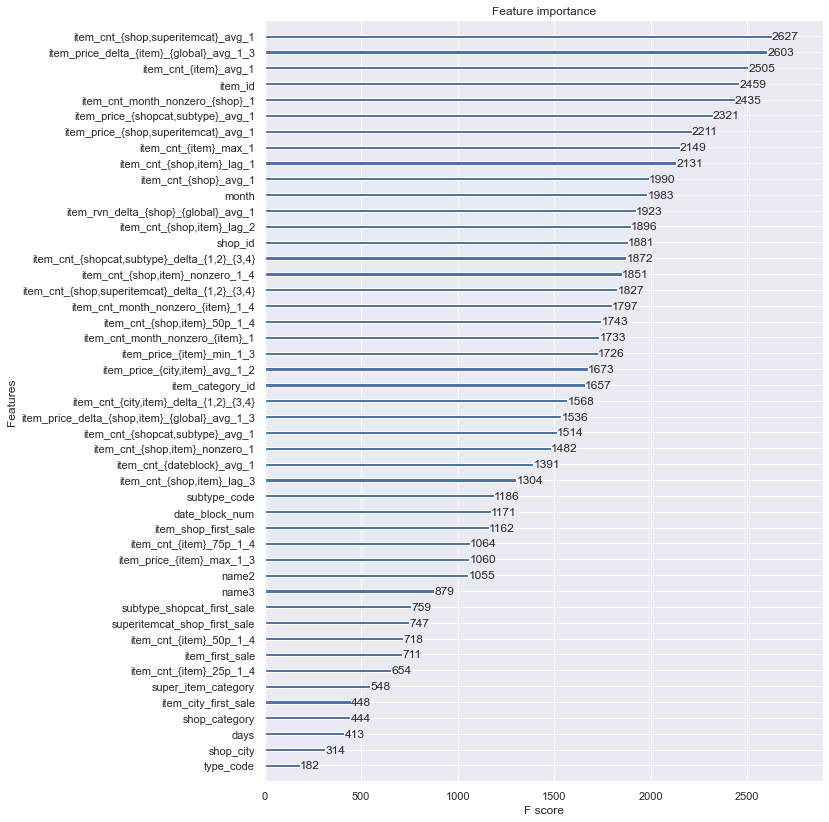

In [285]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

# XGBoost Model (Shop)

In [286]:
uniq_shop_ids = X_test.shop_id.unique()
shops_train = X_train.shop_id
shops_valid = X_valid.shop_id
shops_test = X_test.shop_id

In [287]:

drop_cols = ['shop_id']
            
        
xgb_cols_byshop = [x for x in xgb_cols if x not in drop_cols]

def model_by_shop():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_shop = []

    for shopid in uniq_shop_ids:


        mask_train = (shops_train==shopid).values.flatten()
        mask_valid = (shops_valid==shopid).values.flatten()
        mask_test = (shops_test==shopid).values.flatten()
        
        print(shopid,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<1000 or np.sum(mask_valid)<300:
            miss_shop.append(shopid)
            continue
        
        model = XGBRegressor(
                    max_depth=10, #10
                    n_estimators=1000,
                    min_child_weight= 16, #16
                    colsample_bytree=0.8, 
                    subsample=0.8, 
                    eta=0.09,
                    tree_method='gpu_hist',
                    seed=42)

            

        model.fit(
            X_train[xgb_cols_byshop][mask_train],
            Y_train[mask_train],
            eval_metric="rmse", 
            eval_set=[(X_train[xgb_cols_byshop][mask_train], Y_train[mask_train]),
                      (X_valid[xgb_cols_byshop][mask_valid], Y_valid[mask_valid])], 
            verbose=True, 
            early_stopping_rounds = 20)    
        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid[xgb_cols_byshop][mask_valid]).flatten()
        Y_test[mask_test,0] = model.predict(X_test[xgb_cols_byshop][mask_test]).flatten()
    
    return Y_test,Y_pred,miss_shop,models

In [288]:
Y_test_byshop,Y_pred_byshop,miss_shop,models_byshop = model_by_shop()

Y_test_byshop = np.clip(Y_test_byshop.flatten(),0, 20)

5 195768 5413 5100
[0]	validation_0-rmse:0.84476	validation_1-rmse:0.82007
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.80802	validation_1-rmse:0.78778
[2]	validation_0-rmse:0.77617	validation_1-rmse:0.76146
[3]	validation_0-rmse:0.74814	validation_1-rmse:0.73605
[4]	validation_0-rmse:0.72322	validation_1-rmse:0.71455
[5]	validation_0-rmse:0.70037	validation_1-rmse:0.69390
[6]	validation_0-rmse:0.68029	validation_1-rmse:0.67675
[7]	validation_0-rmse:0.66232	validation_1-rmse:0.66468
[8]	validation_0-rmse:0.64746	validation_1-rmse:0.65615
[9]	validation_0-rmse:0.63423	validation_1-rmse:0.64882
[10]	validation_0-rmse:0.62255	validation_1-rmse:0.64256
[11]	validation_0-rmse:0.61251	validation_1-rmse:0.63700
[12]	validation_0-rmse:0.60350	validation_1-rmse:0.63105
[13]	validation_0-rmse:0.59566	validation_1-rmse:0.62780
[14]	validation_0-rmse:0.58865	val

[20]	validation_0-rmse:0.85797	validation_1-rmse:0.83882
[21]	validation_0-rmse:0.85274	validation_1-rmse:0.83841
[22]	validation_0-rmse:0.84798	validation_1-rmse:0.83832
[23]	validation_0-rmse:0.84387	validation_1-rmse:0.83833
[24]	validation_0-rmse:0.83845	validation_1-rmse:0.83976
[25]	validation_0-rmse:0.83448	validation_1-rmse:0.84026
[26]	validation_0-rmse:0.82976	validation_1-rmse:0.84061
[27]	validation_0-rmse:0.82647	validation_1-rmse:0.84073
[28]	validation_0-rmse:0.82263	validation_1-rmse:0.84305
[29]	validation_0-rmse:0.81902	validation_1-rmse:0.84409
[30]	validation_0-rmse:0.81615	validation_1-rmse:0.84612
[31]	validation_0-rmse:0.81399	validation_1-rmse:0.84528
[32]	validation_0-rmse:0.81114	validation_1-rmse:0.84737
[33]	validation_0-rmse:0.80919	validation_1-rmse:0.84721
[34]	validation_0-rmse:0.80681	validation_1-rmse:0.84678
[35]	validation_0-rmse:0.80360	validation_1-rmse:0.84613
[36]	validation_0-rmse:0.80150	validation_1-rmse:0.84663
[37]	validation_0-rmse:0.80031	

[11]	validation_0-rmse:0.74046	validation_1-rmse:0.72225
[12]	validation_0-rmse:0.72844	validation_1-rmse:0.71471
[13]	validation_0-rmse:0.71831	validation_1-rmse:0.70921
[14]	validation_0-rmse:0.70930	validation_1-rmse:0.70476
[15]	validation_0-rmse:0.70065	validation_1-rmse:0.69877
[16]	validation_0-rmse:0.69273	validation_1-rmse:0.69515
[17]	validation_0-rmse:0.68623	validation_1-rmse:0.69388
[18]	validation_0-rmse:0.67991	validation_1-rmse:0.69087
[19]	validation_0-rmse:0.67419	validation_1-rmse:0.68698
[20]	validation_0-rmse:0.66896	validation_1-rmse:0.68489
[21]	validation_0-rmse:0.66397	validation_1-rmse:0.68131
[22]	validation_0-rmse:0.65952	validation_1-rmse:0.68165
[23]	validation_0-rmse:0.65546	validation_1-rmse:0.67969
[24]	validation_0-rmse:0.65173	validation_1-rmse:0.67796
[25]	validation_0-rmse:0.64814	validation_1-rmse:0.67621
[26]	validation_0-rmse:0.64456	validation_1-rmse:0.67611
[27]	validation_0-rmse:0.64158	validation_1-rmse:0.67473
[28]	validation_0-rmse:0.63879	

[3]	validation_0-rmse:1.69705	validation_1-rmse:1.25372
[4]	validation_0-rmse:1.63694	validation_1-rmse:1.22006
[5]	validation_0-rmse:1.58255	validation_1-rmse:1.18870
[6]	validation_0-rmse:1.53394	validation_1-rmse:1.16592
[7]	validation_0-rmse:1.49157	validation_1-rmse:1.14929
[8]	validation_0-rmse:1.45604	validation_1-rmse:1.13615
[9]	validation_0-rmse:1.42401	validation_1-rmse:1.12797
[10]	validation_0-rmse:1.39477	validation_1-rmse:1.11736
[11]	validation_0-rmse:1.36802	validation_1-rmse:1.10959
[12]	validation_0-rmse:1.34595	validation_1-rmse:1.10322
[13]	validation_0-rmse:1.32681	validation_1-rmse:1.09974
[14]	validation_0-rmse:1.30965	validation_1-rmse:1.09723
[15]	validation_0-rmse:1.29467	validation_1-rmse:1.09398
[16]	validation_0-rmse:1.28130	validation_1-rmse:1.09365
[17]	validation_0-rmse:1.26867	validation_1-rmse:1.08943
[18]	validation_0-rmse:1.25648	validation_1-rmse:1.08697
[19]	validation_0-rmse:1.24579	validation_1-rmse:1.08650
[20]	validation_0-rmse:1.23648	validat

[18]	validation_0-rmse:0.74477	validation_1-rmse:0.82372
[19]	validation_0-rmse:0.73976	validation_1-rmse:0.82178
[20]	validation_0-rmse:0.73482	validation_1-rmse:0.82270
[21]	validation_0-rmse:0.73092	validation_1-rmse:0.82355
[22]	validation_0-rmse:0.72689	validation_1-rmse:0.82311
[23]	validation_0-rmse:0.72405	validation_1-rmse:0.82234
[24]	validation_0-rmse:0.71897	validation_1-rmse:0.82376
[25]	validation_0-rmse:0.71608	validation_1-rmse:0.82347
[26]	validation_0-rmse:0.71218	validation_1-rmse:0.82152
[27]	validation_0-rmse:0.70939	validation_1-rmse:0.82327
[28]	validation_0-rmse:0.70650	validation_1-rmse:0.82403
[29]	validation_0-rmse:0.70381	validation_1-rmse:0.82354
[30]	validation_0-rmse:0.70084	validation_1-rmse:0.82370
[31]	validation_0-rmse:0.69854	validation_1-rmse:0.82639
[32]	validation_0-rmse:0.69699	validation_1-rmse:0.82592
[33]	validation_0-rmse:0.69579	validation_1-rmse:0.82599
[34]	validation_0-rmse:0.69361	validation_1-rmse:0.82700
[35]	validation_0-rmse:0.69132	

[12]	validation_0-rmse:0.73482	validation_1-rmse:0.82734
[13]	validation_0-rmse:0.72198	validation_1-rmse:0.81731
[14]	validation_0-rmse:0.71005	validation_1-rmse:0.80938
[15]	validation_0-rmse:0.69887	validation_1-rmse:0.79691
[16]	validation_0-rmse:0.68967	validation_1-rmse:0.78941
[17]	validation_0-rmse:0.68153	validation_1-rmse:0.78506
[18]	validation_0-rmse:0.67463	validation_1-rmse:0.77792
[19]	validation_0-rmse:0.66755	validation_1-rmse:0.77378
[20]	validation_0-rmse:0.66247	validation_1-rmse:0.77165
[21]	validation_0-rmse:0.65578	validation_1-rmse:0.76774
[22]	validation_0-rmse:0.65157	validation_1-rmse:0.76525
[23]	validation_0-rmse:0.64759	validation_1-rmse:0.76257
[24]	validation_0-rmse:0.64443	validation_1-rmse:0.76190
[25]	validation_0-rmse:0.64084	validation_1-rmse:0.75970
[26]	validation_0-rmse:0.63783	validation_1-rmse:0.75904
[27]	validation_0-rmse:0.63530	validation_1-rmse:0.75929
[28]	validation_0-rmse:0.63294	validation_1-rmse:0.75801
[29]	validation_0-rmse:0.63004	

[23]	validation_0-rmse:0.70496	validation_1-rmse:0.84891
[24]	validation_0-rmse:0.70225	validation_1-rmse:0.84795
[25]	validation_0-rmse:0.69970	validation_1-rmse:0.84749
[26]	validation_0-rmse:0.69760	validation_1-rmse:0.84639
[27]	validation_0-rmse:0.69528	validation_1-rmse:0.84690
[28]	validation_0-rmse:0.69301	validation_1-rmse:0.84681
[29]	validation_0-rmse:0.69100	validation_1-rmse:0.84622
[30]	validation_0-rmse:0.68921	validation_1-rmse:0.84615
[31]	validation_0-rmse:0.68821	validation_1-rmse:0.84612
[32]	validation_0-rmse:0.68687	validation_1-rmse:0.84589
[33]	validation_0-rmse:0.68577	validation_1-rmse:0.84525
[34]	validation_0-rmse:0.68412	validation_1-rmse:0.84774
[35]	validation_0-rmse:0.68210	validation_1-rmse:0.84727
[36]	validation_0-rmse:0.68124	validation_1-rmse:0.84694
[37]	validation_0-rmse:0.67997	validation_1-rmse:0.84805
[38]	validation_0-rmse:0.67868	validation_1-rmse:0.84811
[39]	validation_0-rmse:0.67730	validation_1-rmse:0.84809
[40]	validation_0-rmse:0.67680	

[3]	validation_0-rmse:0.92907	validation_1-rmse:0.83495
[4]	validation_0-rmse:0.89540	validation_1-rmse:0.81310
[5]	validation_0-rmse:0.86489	validation_1-rmse:0.79416
[6]	validation_0-rmse:0.83839	validation_1-rmse:0.77966
[7]	validation_0-rmse:0.81408	validation_1-rmse:0.76547
[8]	validation_0-rmse:0.79214	validation_1-rmse:0.75638
[9]	validation_0-rmse:0.77403	validation_1-rmse:0.75002
[10]	validation_0-rmse:0.75766	validation_1-rmse:0.74228
[11]	validation_0-rmse:0.74263	validation_1-rmse:0.73239
[12]	validation_0-rmse:0.72953	validation_1-rmse:0.73034
[13]	validation_0-rmse:0.71783	validation_1-rmse:0.72669
[14]	validation_0-rmse:0.70714	validation_1-rmse:0.72404
[15]	validation_0-rmse:0.69793	validation_1-rmse:0.72080
[16]	validation_0-rmse:0.69070	validation_1-rmse:0.71784
[17]	validation_0-rmse:0.68320	validation_1-rmse:0.71795
[18]	validation_0-rmse:0.67578	validation_1-rmse:0.71518
[19]	validation_0-rmse:0.66906	validation_1-rmse:0.71376
[20]	validation_0-rmse:0.66305	validat

[7]	validation_0-rmse:1.26448	validation_1-rmse:1.57548
[8]	validation_0-rmse:1.23700	validation_1-rmse:1.55498
[9]	validation_0-rmse:1.21449	validation_1-rmse:1.53587
[10]	validation_0-rmse:1.19334	validation_1-rmse:1.51514
[11]	validation_0-rmse:1.17429	validation_1-rmse:1.50188
[12]	validation_0-rmse:1.15767	validation_1-rmse:1.49055
[13]	validation_0-rmse:1.14307	validation_1-rmse:1.48446
[14]	validation_0-rmse:1.12917	validation_1-rmse:1.47772
[15]	validation_0-rmse:1.11667	validation_1-rmse:1.47306
[16]	validation_0-rmse:1.10556	validation_1-rmse:1.46746
[17]	validation_0-rmse:1.09697	validation_1-rmse:1.46289
[18]	validation_0-rmse:1.08821	validation_1-rmse:1.45945
[19]	validation_0-rmse:1.08024	validation_1-rmse:1.45585
[20]	validation_0-rmse:1.07225	validation_1-rmse:1.45454
[21]	validation_0-rmse:1.06630	validation_1-rmse:1.45441
[22]	validation_0-rmse:1.06068	validation_1-rmse:1.45241
[23]	validation_0-rmse:1.05530	validation_1-rmse:1.44870
[24]	validation_0-rmse:1.04941	val

[1]	validation_0-rmse:0.62399	validation_1-rmse:0.58403
[2]	validation_0-rmse:0.59491	validation_1-rmse:0.56114
[3]	validation_0-rmse:0.56854	validation_1-rmse:0.53821
[4]	validation_0-rmse:0.54529	validation_1-rmse:0.51714
[5]	validation_0-rmse:0.52443	validation_1-rmse:0.49885
[6]	validation_0-rmse:0.50673	validation_1-rmse:0.48717
[7]	validation_0-rmse:0.49141	validation_1-rmse:0.47752
[8]	validation_0-rmse:0.47739	validation_1-rmse:0.46886
[9]	validation_0-rmse:0.46551	validation_1-rmse:0.46142
[10]	validation_0-rmse:0.45487	validation_1-rmse:0.45749
[11]	validation_0-rmse:0.44547	validation_1-rmse:0.44991
[12]	validation_0-rmse:0.43721	validation_1-rmse:0.44448
[13]	validation_0-rmse:0.43000	validation_1-rmse:0.44155
[14]	validation_0-rmse:0.42329	validation_1-rmse:0.43839
[15]	validation_0-rmse:0.41799	validation_1-rmse:0.43582
[16]	validation_0-rmse:0.41286	validation_1-rmse:0.43504
[17]	validation_0-rmse:0.40870	validation_1-rmse:0.43326
[18]	validation_0-rmse:0.40507	validatio

[3]	validation_0-rmse:0.93533	validation_1-rmse:0.98365
[4]	validation_0-rmse:0.90135	validation_1-rmse:0.95731
[5]	validation_0-rmse:0.87074	validation_1-rmse:0.93403
[6]	validation_0-rmse:0.84412	validation_1-rmse:0.91733
[7]	validation_0-rmse:0.82092	validation_1-rmse:0.90453
[8]	validation_0-rmse:0.79983	validation_1-rmse:0.89393
[9]	validation_0-rmse:0.78182	validation_1-rmse:0.88592
[10]	validation_0-rmse:0.76524	validation_1-rmse:0.87966
[11]	validation_0-rmse:0.75064	validation_1-rmse:0.87188
[12]	validation_0-rmse:0.73788	validation_1-rmse:0.86586
[13]	validation_0-rmse:0.72714	validation_1-rmse:0.86310
[14]	validation_0-rmse:0.71741	validation_1-rmse:0.85959
[15]	validation_0-rmse:0.70810	validation_1-rmse:0.85956
[16]	validation_0-rmse:0.69968	validation_1-rmse:0.85790
[17]	validation_0-rmse:0.69175	validation_1-rmse:0.85806
[18]	validation_0-rmse:0.68482	validation_1-rmse:0.85666
[19]	validation_0-rmse:0.67858	validation_1-rmse:0.85492
[20]	validation_0-rmse:0.67313	validat

[28]	validation_0-rmse:1.02104	validation_1-rmse:0.82124
[29]	validation_0-rmse:1.01746	validation_1-rmse:0.82310
[30]	validation_0-rmse:1.01354	validation_1-rmse:0.82378
[31]	validation_0-rmse:1.01042	validation_1-rmse:0.82349
[32]	validation_0-rmse:1.00663	validation_1-rmse:0.82281
[33]	validation_0-rmse:1.00356	validation_1-rmse:0.82292
[34]	validation_0-rmse:1.00072	validation_1-rmse:0.82412
[35]	validation_0-rmse:0.99788	validation_1-rmse:0.82540
[36]	validation_0-rmse:0.99536	validation_1-rmse:0.82460
[37]	validation_0-rmse:0.99289	validation_1-rmse:0.82400
Stopping. Best iteration:
[17]	validation_0-rmse:1.09643	validation_1-rmse:0.81791

58 195768 5413 5100
[0]	validation_0-rmse:1.21869	validation_1-rmse:0.90285
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.16259	validation_1-rmse:0.86796
[2]	validation_0-rmse:1.11286	validation_1-rmse:0.84009

[23]	validation_0-rmse:0.58411	validation_1-rmse:0.54031
[24]	validation_0-rmse:0.58066	validation_1-rmse:0.54085
[25]	validation_0-rmse:0.57750	validation_1-rmse:0.54025
[26]	validation_0-rmse:0.57484	validation_1-rmse:0.53973
[27]	validation_0-rmse:0.57269	validation_1-rmse:0.54077
[28]	validation_0-rmse:0.56995	validation_1-rmse:0.54085
[29]	validation_0-rmse:0.56774	validation_1-rmse:0.54115
[30]	validation_0-rmse:0.56514	validation_1-rmse:0.54113
[31]	validation_0-rmse:0.56334	validation_1-rmse:0.54258
[32]	validation_0-rmse:0.56181	validation_1-rmse:0.54261
[33]	validation_0-rmse:0.56070	validation_1-rmse:0.54441
[34]	validation_0-rmse:0.55864	validation_1-rmse:0.54425
[35]	validation_0-rmse:0.55731	validation_1-rmse:0.54532
[36]	validation_0-rmse:0.55562	validation_1-rmse:0.54636
[37]	validation_0-rmse:0.55454	validation_1-rmse:0.54571
[38]	validation_0-rmse:0.55328	validation_1-rmse:0.54572
[39]	validation_0-rmse:0.55257	validation_1-rmse:0.54602
[40]	validation_0-rmse:0.55122	

[60]	validation_0-rmse:0.65875	validation_1-rmse:0.58687
[61]	validation_0-rmse:0.65790	validation_1-rmse:0.58678
[62]	validation_0-rmse:0.65681	validation_1-rmse:0.58658
[63]	validation_0-rmse:0.65646	validation_1-rmse:0.58660
[64]	validation_0-rmse:0.65610	validation_1-rmse:0.58649
[65]	validation_0-rmse:0.65595	validation_1-rmse:0.58660
[66]	validation_0-rmse:0.65560	validation_1-rmse:0.58629
[67]	validation_0-rmse:0.65500	validation_1-rmse:0.58617
[68]	validation_0-rmse:0.65475	validation_1-rmse:0.58621
[69]	validation_0-rmse:0.65389	validation_1-rmse:0.58596
[70]	validation_0-rmse:0.65285	validation_1-rmse:0.58590
[71]	validation_0-rmse:0.65241	validation_1-rmse:0.58593
[72]	validation_0-rmse:0.65216	validation_1-rmse:0.58603
[73]	validation_0-rmse:0.65165	validation_1-rmse:0.58611
[74]	validation_0-rmse:0.65103	validation_1-rmse:0.58643
[75]	validation_0-rmse:0.65068	validation_1-rmse:0.58622
[76]	validation_0-rmse:0.65045	validation_1-rmse:0.58650
[77]	validation_0-rmse:0.65030	

[34]	validation_0-rmse:0.66704	validation_1-rmse:0.74893
[35]	validation_0-rmse:0.66553	validation_1-rmse:0.75029
[36]	validation_0-rmse:0.66392	validation_1-rmse:0.75101
[37]	validation_0-rmse:0.66279	validation_1-rmse:0.75127
[38]	validation_0-rmse:0.66213	validation_1-rmse:0.75191
[39]	validation_0-rmse:0.66009	validation_1-rmse:0.75152
Stopping. Best iteration:
[19]	validation_0-rmse:0.71297	validation_1-rmse:0.73779

38 195768 5413 5100
[0]	validation_0-rmse:0.98848	validation_1-rmse:0.88867
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.94378	validation_1-rmse:0.85124
[2]	validation_0-rmse:0.90464	validation_1-rmse:0.81994
[3]	validation_0-rmse:0.86981	validation_1-rmse:0.79241
[4]	validation_0-rmse:0.83817	validation_1-rmse:0.76936
[5]	validation_0-rmse:0.80996	validation_1-rmse:0.74755
[6]	validation_0-rmse:0.78492	validation_1-rmse:0.72916
[7]

[87]	validation_0-rmse:0.29822	validation_1-rmse:0.41772
[88]	validation_0-rmse:0.29779	validation_1-rmse:0.41758
[89]	validation_0-rmse:0.29768	validation_1-rmse:0.41736
[90]	validation_0-rmse:0.29747	validation_1-rmse:0.41760
[91]	validation_0-rmse:0.29733	validation_1-rmse:0.41763
[92]	validation_0-rmse:0.29720	validation_1-rmse:0.41759
[93]	validation_0-rmse:0.29692	validation_1-rmse:0.41739
[94]	validation_0-rmse:0.29679	validation_1-rmse:0.41746
[95]	validation_0-rmse:0.29663	validation_1-rmse:0.41749
[96]	validation_0-rmse:0.29650	validation_1-rmse:0.41756
[97]	validation_0-rmse:0.29624	validation_1-rmse:0.41747
[98]	validation_0-rmse:0.29600	validation_1-rmse:0.41758
[99]	validation_0-rmse:0.29587	validation_1-rmse:0.41776
[100]	validation_0-rmse:0.29570	validation_1-rmse:0.41766
[101]	validation_0-rmse:0.29544	validation_1-rmse:0.41818
[102]	validation_0-rmse:0.29526	validation_1-rmse:0.41801
[103]	validation_0-rmse:0.29506	validation_1-rmse:0.41814
[104]	validation_0-rmse:0.2

[69]	validation_0-rmse:0.54800	validation_1-rmse:0.50633
[70]	validation_0-rmse:0.54758	validation_1-rmse:0.50612
[71]	validation_0-rmse:0.54652	validation_1-rmse:0.50632
[72]	validation_0-rmse:0.54633	validation_1-rmse:0.50656
[73]	validation_0-rmse:0.54578	validation_1-rmse:0.50638
[74]	validation_0-rmse:0.54513	validation_1-rmse:0.50656
[75]	validation_0-rmse:0.54487	validation_1-rmse:0.50616
[76]	validation_0-rmse:0.54439	validation_1-rmse:0.50610
[77]	validation_0-rmse:0.54404	validation_1-rmse:0.50561
[78]	validation_0-rmse:0.54375	validation_1-rmse:0.50560
[79]	validation_0-rmse:0.54360	validation_1-rmse:0.50588
[80]	validation_0-rmse:0.54325	validation_1-rmse:0.50564
[81]	validation_0-rmse:0.54252	validation_1-rmse:0.50559
[82]	validation_0-rmse:0.54183	validation_1-rmse:0.50561
[83]	validation_0-rmse:0.54153	validation_1-rmse:0.50532
[84]	validation_0-rmse:0.54090	validation_1-rmse:0.50578
[85]	validation_0-rmse:0.53997	validation_1-rmse:0.50619
[86]	validation_0-rmse:0.53969	

[26]	validation_0-rmse:0.45138	validation_1-rmse:0.81744
[27]	validation_0-rmse:0.44986	validation_1-rmse:0.81694
[28]	validation_0-rmse:0.44858	validation_1-rmse:0.81675
[29]	validation_0-rmse:0.44684	validation_1-rmse:0.81748
[30]	validation_0-rmse:0.44590	validation_1-rmse:0.81863
[31]	validation_0-rmse:0.44499	validation_1-rmse:0.81875
[32]	validation_0-rmse:0.44423	validation_1-rmse:0.81880
[33]	validation_0-rmse:0.44331	validation_1-rmse:0.81941
[34]	validation_0-rmse:0.44249	validation_1-rmse:0.81976
[35]	validation_0-rmse:0.44100	validation_1-rmse:0.81993
[36]	validation_0-rmse:0.44011	validation_1-rmse:0.82120
[37]	validation_0-rmse:0.43946	validation_1-rmse:0.82102
[38]	validation_0-rmse:0.43898	validation_1-rmse:0.82092
[39]	validation_0-rmse:0.43785	validation_1-rmse:0.82077
[40]	validation_0-rmse:0.43711	validation_1-rmse:0.82020
[41]	validation_0-rmse:0.43623	validation_1-rmse:0.81999
[42]	validation_0-rmse:0.43581	validation_1-rmse:0.82000
[43]	validation_0-rmse:0.43508	

In [289]:
Y_pred_byshop = Y_pred_byshop.clip(0,20).flatten()

# Ensemble by Shop Id

In [290]:
Y_test_ensem = np.zeros(X_test.shape[0])
Y_pred_ensem = np.zeros(X_valid.shape[0])

for shopid in uniq_shop_ids:
    mask_valid = (shops_valid==shopid).values.flatten()
    mask_test = (shops_test==shopid).values.flatten()
    xgb_val_loss = np.mean((Y_valid[mask_valid]-Y_pred[mask_valid])**2)
    net_val_loss = np.mean((Y_valid[mask_valid]-Y_pred_byshop[mask_valid].flatten())**2)
    
    if shopid in miss_shop:
        Y_test_ensem[mask_test] = Y_test[mask_test]
        Y_pred_ensem[mask_valid] = Y_pred[mask_valid]
    elif xgb_val_loss<net_val_loss:
        Y_test_ensem[mask_test] = Y_test[mask_test]
        Y_pred_ensem[mask_valid] = Y_pred[mask_valid]
    else:
        Y_test_ensem[mask_test] = Y_test[mask_test]*0.5 + Y_test_byshop[mask_test].flatten()*0.5
        Y_pred_ensem[mask_valid] = Y_pred[mask_valid]*0.5 + Y_pred_byshop[mask_valid].flatten()*0.5
    
    print(shopid,xgb_val_loss,net_val_loss,xgb_val_loss>net_val_loss)

5 0.3759124 0.37865667010272824 False
4 0.25864768 0.23749767193012694 True
6 0.7074457 0.702776872191994 True
3 0.21645154 0.2073879024737907 True
2 0.33697963 0.3447418486603898 False
7 0.4519009 0.4518235142980043 True
11 0.21365023 0.1893063538887311 True
12 0.8373651 0.7085548299615719 True
28 1.1649195 1.175873539467482 False
31 2.259074 2.29080609635929 False
26 0.65399486 0.6748876585789171 False
25 2.691738 2.593306405878829 True
22 0.57916635 0.5508928210745717 True
24 0.5518932 0.6147262862148997 False
21 0.72408533 0.7144384886211326 True
15 0.47524366 0.47865283059787184 False
16 0.3503558 0.3466484325117145 True
18 0.5077243 0.5059349246515987 True
14 0.40970513 0.39360901395363324 True
19 0.54765147 0.5587354864170585 False
42 2.1315117 2.067969384041824 True
50 0.37099865 0.37102047349939116 False
49 0.17907141 0.18212260914863151 False
53 0.37945506 0.40922467022198533 False
52 0.28073886 0.2931703811876464 False
47 0.6787103 0.7296069431075694 False
48 0.4038048 0.423

In [291]:
np.mean(Y_test),np.mean(Y_test_byshop)

(0.2883679, 0.3190253585614577)

In [292]:
print(Y_test_ensem.mean())

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem
})
submission.to_csv('ensemble_submission.csv', index=False)

0.2936245120497617


In [293]:
uniq_sic_ids = X_test.super_item_category.unique()
sic_train = X_train.super_item_category
sic_valid = X_valid.super_item_category
sic_test = X_test.super_item_category

In [294]:
drop_cols = ['super_item_category']
            
        
xgb_cols_bysic = [x for x in xgb_cols if x not in drop_cols]

def model_by_sic():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_sic = []

    for sicid in uniq_sic_ids:


        mask_train = (sic_train==sicid).values.flatten()
        mask_valid = (sic_valid==sicid).values.flatten()
        mask_test = (sic_test==sicid).values.flatten()
        
        
        print(sicid,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<1000 or np.sum(mask_valid)<300:
            miss_sic.append(sicid)
            continue
        
        
        model = XGBRegressor(
                    max_depth=10, #10
                    n_estimators=1000,
                    min_child_weight= 16, #16
                    colsample_bytree=0.8, 
                    subsample=0.8, 
                    eta=0.09,
                    tree_method='gpu_hist',
                    seed=42)

            

        model.fit(
            X_train[xgb_cols_bysic][mask_train],
            Y_train[mask_train],
            eval_metric="rmse", 
            eval_set=[(X_train[xgb_cols_bysic][mask_train], Y_train[mask_train]),
                      (X_valid[xgb_cols_bysic][mask_valid], Y_valid[mask_valid])], 
            verbose=True, 
            early_stopping_rounds = 20)    
        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid[xgb_cols_bysic][mask_valid]).flatten()
        Y_test[mask_test,0] = model.predict(X_test[xgb_cols_bysic][mask_test]).flatten()
    
    return Y_test,Y_pred,miss_sic,models

In [295]:
Y_test_bysic,Y_pred_bysic,miss_sic,_ = model_by_sic()

Y_test_bysic = np.clip(Y_test_bysic.flatten(),0, 20)
Y_pred_bysic = np.clip(Y_pred_bysic.flatten(),0, 20)

7 709867 22962 23268
[0]	validation_0-rmse:1.86546	validation_1-rmse:1.67491
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.78759	validation_1-rmse:1.62014
[2]	validation_0-rmse:1.71748	validation_1-rmse:1.57739
[3]	validation_0-rmse:1.65742	validation_1-rmse:1.54152
[4]	validation_0-rmse:1.60132	validation_1-rmse:1.52419
[5]	validation_0-rmse:1.55496	validation_1-rmse:1.49798
[6]	validation_0-rmse:1.51243	validation_1-rmse:1.47593
[7]	validation_0-rmse:1.47636	validation_1-rmse:1.45758
[8]	validation_0-rmse:1.44595	validation_1-rmse:1.44466
[9]	validation_0-rmse:1.41927	validation_1-rmse:1.43303
[10]	validation_0-rmse:1.39176	validation_1-rmse:1.42442
[11]	validation_0-rmse:1.36861	validation_1-rmse:1.41484
[12]	validation_0-rmse:1.34744	validation_1-rmse:1.40890
[13]	validation_0-rmse:1.32853	validation_1-rmse:1.40721
[14]	validation_0-rmse:1.31159	v

[11]	validation_0-rmse:1.30688	validation_1-rmse:1.12284
[12]	validation_0-rmse:1.28283	validation_1-rmse:1.11426
[13]	validation_0-rmse:1.26031	validation_1-rmse:1.10512
[14]	validation_0-rmse:1.23995	validation_1-rmse:1.10109
[15]	validation_0-rmse:1.22223	validation_1-rmse:1.09942
[16]	validation_0-rmse:1.20320	validation_1-rmse:1.09908
[17]	validation_0-rmse:1.18811	validation_1-rmse:1.09582
[18]	validation_0-rmse:1.17635	validation_1-rmse:1.09237
[19]	validation_0-rmse:1.16493	validation_1-rmse:1.09173
[20]	validation_0-rmse:1.14745	validation_1-rmse:1.08744
[21]	validation_0-rmse:1.13786	validation_1-rmse:1.08522
[22]	validation_0-rmse:1.12902	validation_1-rmse:1.08533
[23]	validation_0-rmse:1.12041	validation_1-rmse:1.08552
[24]	validation_0-rmse:1.11103	validation_1-rmse:1.08683
[25]	validation_0-rmse:1.10244	validation_1-rmse:1.08557
[26]	validation_0-rmse:1.09674	validation_1-rmse:1.08832
[27]	validation_0-rmse:1.08924	validation_1-rmse:1.08973
[28]	validation_0-rmse:1.08206	

[22]	validation_0-rmse:1.45714	validation_1-rmse:1.52750
[23]	validation_0-rmse:1.43610	validation_1-rmse:1.51743
[24]	validation_0-rmse:1.41664	validation_1-rmse:1.50514
[25]	validation_0-rmse:1.39907	validation_1-rmse:1.49469
[26]	validation_0-rmse:1.38185	validation_1-rmse:1.48197
[27]	validation_0-rmse:1.36568	validation_1-rmse:1.47301
[28]	validation_0-rmse:1.35163	validation_1-rmse:1.46872
[29]	validation_0-rmse:1.33881	validation_1-rmse:1.46146
[30]	validation_0-rmse:1.32569	validation_1-rmse:1.45807
[31]	validation_0-rmse:1.31493	validation_1-rmse:1.45570
[32]	validation_0-rmse:1.30391	validation_1-rmse:1.45029
[33]	validation_0-rmse:1.29499	validation_1-rmse:1.45024
[34]	validation_0-rmse:1.28374	validation_1-rmse:1.44764
[35]	validation_0-rmse:1.27208	validation_1-rmse:1.44310
[36]	validation_0-rmse:1.26323	validation_1-rmse:1.43907
[37]	validation_0-rmse:1.25635	validation_1-rmse:1.43840
[38]	validation_0-rmse:1.24913	validation_1-rmse:1.43952
[39]	validation_0-rmse:1.24140	

[27]	validation_0-rmse:0.64359	validation_1-rmse:0.72361
[28]	validation_0-rmse:0.64196	validation_1-rmse:0.72286
[29]	validation_0-rmse:0.64084	validation_1-rmse:0.72190
[30]	validation_0-rmse:0.63892	validation_1-rmse:0.72216
[31]	validation_0-rmse:0.63735	validation_1-rmse:0.72157
[32]	validation_0-rmse:0.63636	validation_1-rmse:0.72129
[33]	validation_0-rmse:0.63540	validation_1-rmse:0.72092
[34]	validation_0-rmse:0.63445	validation_1-rmse:0.72081
[35]	validation_0-rmse:0.63236	validation_1-rmse:0.72080
[36]	validation_0-rmse:0.63081	validation_1-rmse:0.72054
[37]	validation_0-rmse:0.62652	validation_1-rmse:0.72062
[38]	validation_0-rmse:0.62524	validation_1-rmse:0.72097
[39]	validation_0-rmse:0.62443	validation_1-rmse:0.72060
[40]	validation_0-rmse:0.62217	validation_1-rmse:0.72050
[41]	validation_0-rmse:0.62136	validation_1-rmse:0.72058
[42]	validation_0-rmse:0.61985	validation_1-rmse:0.72093
[43]	validation_0-rmse:0.61888	validation_1-rmse:0.72093
[44]	validation_0-rmse:0.61828	

[40]	validation_0-rmse:0.36473	validation_1-rmse:1.01736
[41]	validation_0-rmse:0.36418	validation_1-rmse:1.01739
[42]	validation_0-rmse:0.36365	validation_1-rmse:1.01728
[43]	validation_0-rmse:0.36306	validation_1-rmse:1.01726
[44]	validation_0-rmse:0.36271	validation_1-rmse:1.01716
[45]	validation_0-rmse:0.36227	validation_1-rmse:1.01695
[46]	validation_0-rmse:0.36185	validation_1-rmse:1.01682
[47]	validation_0-rmse:0.36143	validation_1-rmse:1.01673
[48]	validation_0-rmse:0.36100	validation_1-rmse:1.01672
[49]	validation_0-rmse:0.36084	validation_1-rmse:1.01690
[50]	validation_0-rmse:0.36059	validation_1-rmse:1.01673
[51]	validation_0-rmse:0.36005	validation_1-rmse:1.01655
[52]	validation_0-rmse:0.35958	validation_1-rmse:1.01641
[53]	validation_0-rmse:0.35926	validation_1-rmse:1.01636
[54]	validation_0-rmse:0.35905	validation_1-rmse:1.01633
[55]	validation_0-rmse:0.35878	validation_1-rmse:1.01630
[56]	validation_0-rmse:0.35841	validation_1-rmse:1.01622
[57]	validation_0-rmse:0.35801	

[53]	validation_0-rmse:0.41776	validation_1-rmse:0.42899
[54]	validation_0-rmse:0.41702	validation_1-rmse:0.42869
[55]	validation_0-rmse:0.41651	validation_1-rmse:0.42847
[56]	validation_0-rmse:0.41590	validation_1-rmse:0.42823
[57]	validation_0-rmse:0.41518	validation_1-rmse:0.42792
[58]	validation_0-rmse:0.41433	validation_1-rmse:0.42815
[59]	validation_0-rmse:0.41342	validation_1-rmse:0.42769
[60]	validation_0-rmse:0.41281	validation_1-rmse:0.42741
[61]	validation_0-rmse:0.41222	validation_1-rmse:0.42785
[62]	validation_0-rmse:0.41163	validation_1-rmse:0.42783
[63]	validation_0-rmse:0.41134	validation_1-rmse:0.42795
[64]	validation_0-rmse:0.41103	validation_1-rmse:0.42776
[65]	validation_0-rmse:0.41050	validation_1-rmse:0.42772
[66]	validation_0-rmse:0.41001	validation_1-rmse:0.42784
[67]	validation_0-rmse:0.40975	validation_1-rmse:0.42788
[68]	validation_0-rmse:0.40947	validation_1-rmse:0.42811
[69]	validation_0-rmse:0.40925	validation_1-rmse:0.42811
[70]	validation_0-rmse:0.40851	

[33]	validation_0-rmse:0.40231	validation_1-rmse:0.79100
[34]	validation_0-rmse:0.39785	validation_1-rmse:0.79963
[35]	validation_0-rmse:0.39265	validation_1-rmse:0.80436
[36]	validation_0-rmse:0.38782	validation_1-rmse:0.82011
[37]	validation_0-rmse:0.38262	validation_1-rmse:0.82111
[38]	validation_0-rmse:0.37537	validation_1-rmse:0.82190
[39]	validation_0-rmse:0.37144	validation_1-rmse:0.82189
[40]	validation_0-rmse:0.36786	validation_1-rmse:0.82919
[41]	validation_0-rmse:0.36451	validation_1-rmse:0.82829
[42]	validation_0-rmse:0.35873	validation_1-rmse:0.82976
Stopping. Best iteration:
[22]	validation_0-rmse:0.53250	validation_1-rmse:0.75975

14 0 0 42
17 1279 129 126


In [296]:
Y_test_ensem_2 = np.zeros(X_test.shape[0])
Y_pred_ensem_2 = np.zeros(X_valid.shape[0])

for sicid in uniq_sic_ids:
    mask_valid = (sic_valid==sicid).values.flatten()
    mask_test = (sic_test==sicid).values.flatten()
    xgb_val_loss = np.mean((Y_valid[mask_valid]-Y_pred_ensem[mask_valid])**2)
    net_val_loss = np.mean((Y_valid[mask_valid]-Y_pred_bysic[mask_valid].flatten())**2)
    
    if sicid in miss_sic:
        Y_test_ensem_2[mask_test] = Y_test_ensem[mask_test]
        Y_pred_ensem_2[mask_valid] = Y_pred_ensem[mask_valid]
    elif xgb_val_loss<net_val_loss:
        Y_test_ensem_2[mask_test] = Y_test_ensem[mask_test]
        Y_pred_ensem_2[mask_valid] = Y_pred_ensem[mask_valid]
    else:
        Y_test_ensem_2[mask_test] = Y_test_ensem[mask_test]*0.7 + Y_test_bysic[mask_test].flatten()*0.3
        Y_pred_ensem_2[mask_valid] = Y_pred_ensem[mask_valid]*0.7 + Y_pred_bysic[mask_valid].flatten()*0.3
    
    print(sicid,xgb_val_loss,net_val_loss,xgb_val_loss>net_val_loss)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem_2
})
submission.to_csv('ensemble_plusnet_submission.csv', index=False)

7 1.8659520761651687 1.9702341367527167 False
12 0.2149210245131307 0.2129425799704305 True
3 1.1760198109685998 1.1472220297423001 True
10 0.9506632262117337 0.8057547391222686 True
4 1.9412751308078173 2.0641174111719227 False
0 0.6401219241011205 0.7016748740918761 False
11 0.5233941467757676 0.5165678360383394 True
6 0.3574112818973032 0.27106552361503045 True
2 1.0514959343885733 1.0317742922984998 True
13 10.244642288916518 162.67441860465115 False
1 0.3087702804278805 0.3129474465455109 False
15 0.19263270724247417 0.18014524732474163 True
9 4.180404672138572 13.819767441860465 False
8 0.65463901341096 0.577111470996856 True
14 nan nan False
17 0.4794729063275587 0.5116279069767442 False


In [297]:
np.mean(Y_test_ensem_2)

0.2943785955179361

In [298]:
uniq_city_ids = X_test.shop_city.unique()
city_train = X_train.shop_city
city_valid = X_valid.shop_city
city_test = X_test.shop_city

drop_cols = ['shop_city']
        
xgb_cols_bycity = [x for x in xgb_cols if x not in drop_cols]


def model_by_city():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_city = []

    for city in uniq_city_ids:


        mask_train = (city_train==city).values.flatten()
        mask_valid = (city_valid==city).values.flatten()
        mask_test = (city_test==city).values.flatten()
        
        print(city,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<300 or np.sum(mask_valid)<100:
            miss_city.append(city)
            continue
            
        model = XGBRegressor(
                    max_depth=10, #10
                    n_estimators=1000,
                    min_child_weight= 16, #16
                    colsample_bytree=0.8, 
                    subsample=0.8, 
                    eta=0.09,
                    tree_method='gpu_hist',
                    seed=42)

            

        model.fit(
            X_train[xgb_cols_bycity][mask_train],
            Y_train[mask_train],
            eval_metric="rmse", 
            eval_set=[(X_train[xgb_cols_bycity][mask_train], Y_train[mask_train]),
                      (X_valid[xgb_cols_bycity][mask_valid], Y_valid[mask_valid])], 
            verbose=True, 
            early_stopping_rounds = 20)    
        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid[xgb_cols_bycity][mask_valid]).flatten()
        Y_test[mask_test,0] = model.predict(X_test[xgb_cols_bycity][mask_test]).flatten()
    return Y_test,Y_pred,miss_city,models

In [299]:
Y_test_bycity,Y_pred_bycity,miss_city,_ = model_by_city()

Y_test_bycity = np.clip(Y_test_bycity.flatten(),0, 20)
Y_pred_bycity = np.clip(Y_pred_bycity.flatten(),0, 20)

3 195768 5413 5100
[0]	validation_0-rmse:0.84475	validation_1-rmse:0.81843
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.80801	validation_1-rmse:0.78557
[2]	validation_0-rmse:0.77610	validation_1-rmse:0.75960
[3]	validation_0-rmse:0.74770	validation_1-rmse:0.73477
[4]	validation_0-rmse:0.72288	validation_1-rmse:0.71360
[5]	validation_0-rmse:0.70004	validation_1-rmse:0.69309
[6]	validation_0-rmse:0.68000	validation_1-rmse:0.67601
[7]	validation_0-rmse:0.66210	validation_1-rmse:0.66360
[8]	validation_0-rmse:0.64732	validation_1-rmse:0.65397
[9]	validation_0-rmse:0.63441	validation_1-rmse:0.64608
[10]	validation_0-rmse:0.62237	validation_1-rmse:0.63933
[11]	validation_0-rmse:0.61205	validation_1-rmse:0.63318
[12]	validation_0-rmse:0.60311	validation_1-rmse:0.62790
[13]	validation_0-rmse:0.59533	validation_1-rmse:0.62536
[14]	validation_0-rmse:0.58841	val

[34]	validation_0-rmse:0.73790	validation_1-rmse:0.75871
[35]	validation_0-rmse:0.73608	validation_1-rmse:0.75778
[36]	validation_0-rmse:0.73364	validation_1-rmse:0.76086
[37]	validation_0-rmse:0.73218	validation_1-rmse:0.76112
[38]	validation_0-rmse:0.73015	validation_1-rmse:0.76092
[39]	validation_0-rmse:0.72892	validation_1-rmse:0.76078
[40]	validation_0-rmse:0.72691	validation_1-rmse:0.75985
[41]	validation_0-rmse:0.72584	validation_1-rmse:0.76023
[42]	validation_0-rmse:0.72483	validation_1-rmse:0.76092
[43]	validation_0-rmse:0.72408	validation_1-rmse:0.76140
[44]	validation_0-rmse:0.72301	validation_1-rmse:0.76141
[45]	validation_0-rmse:0.72139	validation_1-rmse:0.76290
[46]	validation_0-rmse:0.72026	validation_1-rmse:0.76357
[47]	validation_0-rmse:0.71897	validation_1-rmse:0.76348
[48]	validation_0-rmse:0.71741	validation_1-rmse:0.76379
[49]	validation_0-rmse:0.71661	validation_1-rmse:0.76397
[50]	validation_0-rmse:0.71496	validation_1-rmse:0.76413
Stopping. Best iteration:
[30]	

[10]	validation_0-rmse:0.47684	validation_1-rmse:0.44860
[11]	validation_0-rmse:0.46729	validation_1-rmse:0.44403
[12]	validation_0-rmse:0.45867	validation_1-rmse:0.44269
[13]	validation_0-rmse:0.45109	validation_1-rmse:0.43993
[14]	validation_0-rmse:0.44458	validation_1-rmse:0.43874
[15]	validation_0-rmse:0.43832	validation_1-rmse:0.43718
[16]	validation_0-rmse:0.43372	validation_1-rmse:0.43629
[17]	validation_0-rmse:0.42934	validation_1-rmse:0.43667
[18]	validation_0-rmse:0.42554	validation_1-rmse:0.43709
[19]	validation_0-rmse:0.42201	validation_1-rmse:0.43669
[20]	validation_0-rmse:0.41842	validation_1-rmse:0.43637
[21]	validation_0-rmse:0.41554	validation_1-rmse:0.43864
[22]	validation_0-rmse:0.41365	validation_1-rmse:0.44036
[23]	validation_0-rmse:0.41138	validation_1-rmse:0.44136
[24]	validation_0-rmse:0.40921	validation_1-rmse:0.44169
[25]	validation_0-rmse:0.40753	validation_1-rmse:0.44175
[26]	validation_0-rmse:0.40578	validation_1-rmse:0.44189
[27]	validation_0-rmse:0.40477	

[71]	validation_0-rmse:0.95625	validation_1-rmse:1.25376
[72]	validation_0-rmse:0.95551	validation_1-rmse:1.25375
[73]	validation_0-rmse:0.95464	validation_1-rmse:1.25386
[74]	validation_0-rmse:0.95374	validation_1-rmse:1.25467
[75]	validation_0-rmse:0.95274	validation_1-rmse:1.25482
[76]	validation_0-rmse:0.95022	validation_1-rmse:1.25565
[77]	validation_0-rmse:0.94934	validation_1-rmse:1.25523
[78]	validation_0-rmse:0.94851	validation_1-rmse:1.25510
[79]	validation_0-rmse:0.94737	validation_1-rmse:1.25499
[80]	validation_0-rmse:0.94676	validation_1-rmse:1.25496
[81]	validation_0-rmse:0.94622	validation_1-rmse:1.25488
Stopping. Best iteration:
[61]	validation_0-rmse:0.96581	validation_1-rmse:1.25218

9 195768 5413 5100
[0]	validation_0-rmse:1.14970	validation_1-rmse:0.99622
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.09706	validation_1-rmse:0.94988

[14]	validation_0-rmse:0.65383	validation_1-rmse:0.73181
[15]	validation_0-rmse:0.64572	validation_1-rmse:0.72903
[16]	validation_0-rmse:0.63900	validation_1-rmse:0.72657
[17]	validation_0-rmse:0.63297	validation_1-rmse:0.72421
[18]	validation_0-rmse:0.62743	validation_1-rmse:0.72303
[19]	validation_0-rmse:0.62201	validation_1-rmse:0.72132
[20]	validation_0-rmse:0.61650	validation_1-rmse:0.71911
[21]	validation_0-rmse:0.61215	validation_1-rmse:0.71901
[22]	validation_0-rmse:0.60827	validation_1-rmse:0.71948
[23]	validation_0-rmse:0.60481	validation_1-rmse:0.71987
[24]	validation_0-rmse:0.60084	validation_1-rmse:0.71860
[25]	validation_0-rmse:0.59713	validation_1-rmse:0.71671
[26]	validation_0-rmse:0.59433	validation_1-rmse:0.71805
[27]	validation_0-rmse:0.59180	validation_1-rmse:0.71705
[28]	validation_0-rmse:0.58906	validation_1-rmse:0.71801
[29]	validation_0-rmse:0.58681	validation_1-rmse:0.71793
[30]	validation_0-rmse:0.58468	validation_1-rmse:0.71709
[31]	validation_0-rmse:0.58226	

[3]	validation_0-rmse:1.25214	validation_1-rmse:1.69945
[4]	validation_0-rmse:1.21288	validation_1-rmse:1.66315
[5]	validation_0-rmse:1.17705	validation_1-rmse:1.62946
[6]	validation_0-rmse:1.14617	validation_1-rmse:1.60466
[7]	validation_0-rmse:1.11894	validation_1-rmse:1.58484
[8]	validation_0-rmse:1.09487	validation_1-rmse:1.56194
[9]	validation_0-rmse:1.07312	validation_1-rmse:1.54075
[10]	validation_0-rmse:1.05386	validation_1-rmse:1.52680
[11]	validation_0-rmse:1.03738	validation_1-rmse:1.51400
[12]	validation_0-rmse:1.02334	validation_1-rmse:1.50510
[13]	validation_0-rmse:1.01021	validation_1-rmse:1.49830
[14]	validation_0-rmse:0.99752	validation_1-rmse:1.49124
[15]	validation_0-rmse:0.98591	validation_1-rmse:1.48591
[16]	validation_0-rmse:0.97584	validation_1-rmse:1.48033
[17]	validation_0-rmse:0.96700	validation_1-rmse:1.47842
[18]	validation_0-rmse:0.95889	validation_1-rmse:1.47446
[19]	validation_0-rmse:0.95107	validation_1-rmse:1.47148
[20]	validation_0-rmse:0.94333	validat

[13]	validation_0-rmse:0.66315	validation_1-rmse:0.59101
[14]	validation_0-rmse:0.65488	validation_1-rmse:0.58715
[15]	validation_0-rmse:0.64760	validation_1-rmse:0.58478
[16]	validation_0-rmse:0.64109	validation_1-rmse:0.58401
[17]	validation_0-rmse:0.63439	validation_1-rmse:0.58085
[18]	validation_0-rmse:0.62910	validation_1-rmse:0.57920
[19]	validation_0-rmse:0.62390	validation_1-rmse:0.57899
[20]	validation_0-rmse:0.61907	validation_1-rmse:0.57887
[21]	validation_0-rmse:0.61468	validation_1-rmse:0.57852
[22]	validation_0-rmse:0.61044	validation_1-rmse:0.57872
[23]	validation_0-rmse:0.60716	validation_1-rmse:0.57730
[24]	validation_0-rmse:0.60367	validation_1-rmse:0.57692
[25]	validation_0-rmse:0.60103	validation_1-rmse:0.57656
[26]	validation_0-rmse:0.59832	validation_1-rmse:0.57689
[27]	validation_0-rmse:0.59585	validation_1-rmse:0.57698
[28]	validation_0-rmse:0.59362	validation_1-rmse:0.57626
[29]	validation_0-rmse:0.59167	validation_1-rmse:0.57668
[30]	validation_0-rmse:0.58976	

[24]	validation_0-rmse:0.54261	validation_1-rmse:0.64830
[25]	validation_0-rmse:0.53946	validation_1-rmse:0.64849
[26]	validation_0-rmse:0.53658	validation_1-rmse:0.64712
[27]	validation_0-rmse:0.53391	validation_1-rmse:0.64685
[28]	validation_0-rmse:0.53175	validation_1-rmse:0.64641
[29]	validation_0-rmse:0.52922	validation_1-rmse:0.64734
[30]	validation_0-rmse:0.52736	validation_1-rmse:0.64677
[31]	validation_0-rmse:0.52482	validation_1-rmse:0.64635
[32]	validation_0-rmse:0.52256	validation_1-rmse:0.64602
[33]	validation_0-rmse:0.52119	validation_1-rmse:0.64627
[34]	validation_0-rmse:0.51927	validation_1-rmse:0.64609
[35]	validation_0-rmse:0.51746	validation_1-rmse:0.64594
[36]	validation_0-rmse:0.51636	validation_1-rmse:0.64564
[37]	validation_0-rmse:0.51528	validation_1-rmse:0.64562
[38]	validation_0-rmse:0.51430	validation_1-rmse:0.64593
[39]	validation_0-rmse:0.51357	validation_1-rmse:0.64578
[40]	validation_0-rmse:0.51290	validation_1-rmse:0.64615
[41]	validation_0-rmse:0.51141	

[23]	validation_0-rmse:0.58423	validation_1-rmse:0.53766
[24]	validation_0-rmse:0.58092	validation_1-rmse:0.53673
[25]	validation_0-rmse:0.57827	validation_1-rmse:0.53659
[26]	validation_0-rmse:0.57575	validation_1-rmse:0.53560
[27]	validation_0-rmse:0.57339	validation_1-rmse:0.53639
[28]	validation_0-rmse:0.57100	validation_1-rmse:0.53679
[29]	validation_0-rmse:0.56901	validation_1-rmse:0.53763
[30]	validation_0-rmse:0.56697	validation_1-rmse:0.53857
[31]	validation_0-rmse:0.56521	validation_1-rmse:0.53985
[32]	validation_0-rmse:0.56371	validation_1-rmse:0.53895
[33]	validation_0-rmse:0.56252	validation_1-rmse:0.54010
[34]	validation_0-rmse:0.56032	validation_1-rmse:0.54076
[35]	validation_0-rmse:0.55880	validation_1-rmse:0.54153
[36]	validation_0-rmse:0.55688	validation_1-rmse:0.54145
[37]	validation_0-rmse:0.55567	validation_1-rmse:0.54206
[38]	validation_0-rmse:0.55442	validation_1-rmse:0.54143
[39]	validation_0-rmse:0.55315	validation_1-rmse:0.53944
[40]	validation_0-rmse:0.55261	

[25]	validation_0-rmse:0.69748	validation_1-rmse:0.59185
[26]	validation_0-rmse:0.69464	validation_1-rmse:0.58986
[27]	validation_0-rmse:0.69244	validation_1-rmse:0.58886
[28]	validation_0-rmse:0.69030	validation_1-rmse:0.58816
[29]	validation_0-rmse:0.68854	validation_1-rmse:0.58851
[30]	validation_0-rmse:0.68679	validation_1-rmse:0.58862
[31]	validation_0-rmse:0.68497	validation_1-rmse:0.58893
[32]	validation_0-rmse:0.68326	validation_1-rmse:0.58956
[33]	validation_0-rmse:0.68138	validation_1-rmse:0.58838
[34]	validation_0-rmse:0.67985	validation_1-rmse:0.58809
[35]	validation_0-rmse:0.67795	validation_1-rmse:0.58874
[36]	validation_0-rmse:0.67534	validation_1-rmse:0.58971
[37]	validation_0-rmse:0.67428	validation_1-rmse:0.59052
[38]	validation_0-rmse:0.67319	validation_1-rmse:0.58962
[39]	validation_0-rmse:0.67193	validation_1-rmse:0.58982
[40]	validation_0-rmse:0.67042	validation_1-rmse:0.58881
[41]	validation_0-rmse:0.66890	validation_1-rmse:0.58832
[42]	validation_0-rmse:0.66755	

[2]	validation_0-rmse:0.90445	validation_1-rmse:0.82245
[3]	validation_0-rmse:0.86951	validation_1-rmse:0.79486
[4]	validation_0-rmse:0.83831	validation_1-rmse:0.77149
[5]	validation_0-rmse:0.81065	validation_1-rmse:0.74971
[6]	validation_0-rmse:0.78577	validation_1-rmse:0.73066
[7]	validation_0-rmse:0.76435	validation_1-rmse:0.71982
[8]	validation_0-rmse:0.74478	validation_1-rmse:0.70750
[9]	validation_0-rmse:0.72892	validation_1-rmse:0.69744
[10]	validation_0-rmse:0.71367	validation_1-rmse:0.68922
[11]	validation_0-rmse:0.69966	validation_1-rmse:0.68139
[12]	validation_0-rmse:0.68822	validation_1-rmse:0.67873
[13]	validation_0-rmse:0.67773	validation_1-rmse:0.67481
[14]	validation_0-rmse:0.66827	validation_1-rmse:0.67210
[15]	validation_0-rmse:0.65934	validation_1-rmse:0.66980
[16]	validation_0-rmse:0.65189	validation_1-rmse:0.66820
[17]	validation_0-rmse:0.64405	validation_1-rmse:0.66764
[18]	validation_0-rmse:0.63787	validation_1-rmse:0.66544
[19]	validation_0-rmse:0.63142	validati

[41]	validation_0-rmse:0.49649	validation_1-rmse:0.67996
[42]	validation_0-rmse:0.49577	validation_1-rmse:0.67998
[43]	validation_0-rmse:0.49497	validation_1-rmse:0.67985
[44]	validation_0-rmse:0.49430	validation_1-rmse:0.67942
[45]	validation_0-rmse:0.49398	validation_1-rmse:0.67946
[46]	validation_0-rmse:0.49318	validation_1-rmse:0.67994
[47]	validation_0-rmse:0.49275	validation_1-rmse:0.67988
[48]	validation_0-rmse:0.49229	validation_1-rmse:0.67976
[49]	validation_0-rmse:0.49165	validation_1-rmse:0.67963
[50]	validation_0-rmse:0.49128	validation_1-rmse:0.67906
[51]	validation_0-rmse:0.49099	validation_1-rmse:0.67871
[52]	validation_0-rmse:0.49030	validation_1-rmse:0.67873
[53]	validation_0-rmse:0.48902	validation_1-rmse:0.67870
[54]	validation_0-rmse:0.48866	validation_1-rmse:0.67833
[55]	validation_0-rmse:0.48818	validation_1-rmse:0.67797
[56]	validation_0-rmse:0.48798	validation_1-rmse:0.67771
[57]	validation_0-rmse:0.48775	validation_1-rmse:0.67814
[58]	validation_0-rmse:0.48752	

In [300]:
Y_test_ensem_3 = np.zeros(X_test.shape[0])
Y_pred_ensem_3 = np.zeros(X_valid.shape[0])

for city in uniq_city_ids:
    mask_valid = (city_valid==city).values.flatten()
    mask_test = (city_test==city).values.flatten()
    xgb_val_loss = np.mean((Y_valid[mask_valid]-Y_pred_ensem[mask_valid])**2)
    net_val_loss = np.mean((Y_valid[mask_valid]-Y_pred_bycity[mask_valid].flatten())**2)
    
    if city in miss_city:
        Y_test_ensem_3[mask_test] = Y_test_ensem_2[mask_test]
        Y_pred_ensem_3[mask_valid] = Y_pred_ensem_2[mask_valid]
    elif xgb_val_loss<net_val_loss:
        Y_test_ensem_3[mask_test] = Y_test_ensem_2[mask_test]
        Y_pred_ensem_3[mask_valid] = Y_pred_ensem_2[mask_valid]
    else:
        Y_test_ensem_3[mask_test] = Y_test_ensem_2[mask_test]*0.7 + Y_test_bycity[mask_test].flatten()*0.3
        Y_pred_ensem_3[mask_valid] = Y_pred_ensem_2[mask_valid]*0.7 + Y_pred_bycity[mask_valid].flatten()*0.3
    
    print(city,xgb_val_loss,net_val_loss,xgb_val_loss>net_val_loss)

3 0.3759124072962899 0.37674316353301146 False
2 0.2403028550925323 0.24086467035929718 False
4 0.564628608803867 0.5722081625275752 False
1 0.2051584938864319 0.20817147709117295 False
0 0.3369796342959028 0.33316871877359505 True
6 0.19037590935897578 0.1903531772474033 True
7 0.7279250048319849 0.6964825011049397 True
13 1.6166064363936243 1.567729094579948 True
9 0.4752436678952367 0.46883921347003965 True
10 0.3353610058930603 0.34448157565838416 False
11 0.49575831352874583 0.5135725483901962 False
8 0.391750127550843 0.38420634681401317 True
12 0.5476514283256954 0.5560466591919438 False
19 2.0597259749615207 2.1367221462034314 False
24 0.2750350322165518 0.2704904948414662 True
25 0.330096952341257 0.32620931091836086 True
22 0.6787103226740615 0.7250899396211952 False
23 0.4038047858733315 0.41468612110948544 False
29 0.5469842082200227 0.5431196267013665 True
30 0.283505002452445 0.2868718111792431 False
27 0.8656702319884656 0.8295626644018006 True
28 0.34288636355247315 0.3

In [301]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem_3.clip(0,20)
})
submission.to_csv('ensemble_plusnet_3_submission.csv', index=False)

In [302]:
uniq_subtype_ids = X_test.subtype_code.unique()
subtype_train = X_train.subtype_code
subtype_valid = X_valid.subtype_code
subtype_test = X_test.subtype_code

drop_cols = ['subtype_code']
        
xgb_cols_bysubtype = [x for x in xgb_cols if x not in drop_cols]


def model_by_subtype():
    
    models = []
    
    Y_pred = np.zeros([X_valid.shape[0], 1])
    Y_test = np.zeros([X_test.shape[0], 1])

    cur_block_num=34
   
    miss_subtype = []

    for subtype in uniq_subtype_ids:


        mask_train = (subtype_train==subtype).values.flatten()
        mask_valid = (subtype_valid==subtype).values.flatten()
        mask_test = (subtype_test==subtype).values.flatten()
        
        print(subtype,np.sum(mask_train),np.sum(mask_valid),np.sum(mask_test))
        
        if np.sum(mask_train)<300 or np.sum(mask_valid)<100:
            miss_subtype.append(subtype)
            continue
            
        model = XGBRegressor(
                    max_depth=10, #10
                    n_estimators=1000,
                    min_child_weight= 16, #16
                    colsample_bytree=0.8, 
                    subsample=0.8, 
                    eta=0.09,
                    tree_method='gpu_hist',
                    seed=42)

            

        model.fit(
            X_train[xgb_cols_bysubtype][mask_train],
            Y_train[mask_train],
            eval_metric="rmse", 
            eval_set=[(X_train[xgb_cols_bysubtype][mask_train], Y_train[mask_train]),
                      (X_valid[xgb_cols_bysubtype][mask_valid], Y_valid[mask_valid])], 
            verbose=True, 
            early_stopping_rounds = 20)    
        
        models.append(model)

        Y_pred[mask_valid,0] = model.predict(X_valid[xgb_cols_bysubtype][mask_valid]).flatten()
        Y_test[mask_test,0] = model.predict(X_test[xgb_cols_bysubtype][mask_test]).flatten()
    return Y_test,Y_pred,miss_subtype,models

In [303]:
Y_test_bysubtype,Y_pred_bysubtype,miss_subtype,_ = model_by_subtype()

Y_test_bysubtype = np.clip(Y_test_bysubtype.flatten(),0, 20)
Y_pred_bysubtype = np.clip(Y_pred_bysubtype.flatten(),0, 20)

10 340106 7310 6342
[0]	validation_0-rmse:1.70751	validation_1-rmse:0.97937
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.63068	validation_1-rmse:0.94693
[2]	validation_0-rmse:1.56225	validation_1-rmse:0.93095
[3]	validation_0-rmse:1.50709	validation_1-rmse:0.92049
[4]	validation_0-rmse:1.45120	validation_1-rmse:0.90059
[5]	validation_0-rmse:1.40223	validation_1-rmse:0.89523
[6]	validation_0-rmse:1.35912	validation_1-rmse:0.89118
[7]	validation_0-rmse:1.32383	validation_1-rmse:0.88949
[8]	validation_0-rmse:1.29342	validation_1-rmse:0.87827
[9]	validation_0-rmse:1.26486	validation_1-rmse:0.87850
[10]	validation_0-rmse:1.23447	validation_1-rmse:0.87984
[11]	validation_0-rmse:1.21003	validation_1-rmse:0.88132
[12]	validation_0-rmse:1.18908	validation_1-rmse:0.88612
[13]	validation_0-rmse:1.16822	validation_1-rmse:0.88651
[14]	validation_0-rmse:1.15268	va

[6]	validation_0-rmse:2.64015	validation_1-rmse:2.40099
[7]	validation_0-rmse:2.55043	validation_1-rmse:2.36290
[8]	validation_0-rmse:2.48112	validation_1-rmse:2.34993
[9]	validation_0-rmse:2.41273	validation_1-rmse:2.34699
[10]	validation_0-rmse:2.33986	validation_1-rmse:2.34001
[11]	validation_0-rmse:2.28557	validation_1-rmse:2.33463
[12]	validation_0-rmse:2.23422	validation_1-rmse:2.31019
[13]	validation_0-rmse:2.17767	validation_1-rmse:2.30555
[14]	validation_0-rmse:2.12320	validation_1-rmse:2.31119
[15]	validation_0-rmse:2.08442	validation_1-rmse:2.31498
[16]	validation_0-rmse:2.04555	validation_1-rmse:2.31107
[17]	validation_0-rmse:2.00208	validation_1-rmse:2.33989
[18]	validation_0-rmse:1.97299	validation_1-rmse:2.33356
[19]	validation_0-rmse:1.94649	validation_1-rmse:2.34059
[20]	validation_0-rmse:1.91095	validation_1-rmse:2.36169
[21]	validation_0-rmse:1.87884	validation_1-rmse:2.36672
[22]	validation_0-rmse:1.85105	validation_1-rmse:2.36862
[23]	validation_0-rmse:1.83333	vali

[13]	validation_0-rmse:0.61089	validation_1-rmse:0.79268
[14]	validation_0-rmse:0.60220	validation_1-rmse:0.79083
[15]	validation_0-rmse:0.59496	validation_1-rmse:0.78916
[16]	validation_0-rmse:0.58890	validation_1-rmse:0.78714
[17]	validation_0-rmse:0.58331	validation_1-rmse:0.78704
[18]	validation_0-rmse:0.57850	validation_1-rmse:0.78626
[19]	validation_0-rmse:0.57348	validation_1-rmse:0.78502
[20]	validation_0-rmse:0.56903	validation_1-rmse:0.78381
[21]	validation_0-rmse:0.56420	validation_1-rmse:0.78416
[22]	validation_0-rmse:0.56073	validation_1-rmse:0.78388
[23]	validation_0-rmse:0.55722	validation_1-rmse:0.78363
[24]	validation_0-rmse:0.55353	validation_1-rmse:0.78347
[25]	validation_0-rmse:0.54952	validation_1-rmse:0.78409
[26]	validation_0-rmse:0.54710	validation_1-rmse:0.78382
[27]	validation_0-rmse:0.54460	validation_1-rmse:0.78409
[28]	validation_0-rmse:0.54244	validation_1-rmse:0.78409
[29]	validation_0-rmse:0.54055	validation_1-rmse:0.78405
[30]	validation_0-rmse:0.53883	

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.18750	validation_1-rmse:1.02424
[2]	validation_0-rmse:1.14794	validation_1-rmse:1.00762
[3]	validation_0-rmse:1.11127	validation_1-rmse:0.98978
[4]	validation_0-rmse:1.07667	validation_1-rmse:0.97991
[5]	validation_0-rmse:1.04577	validation_1-rmse:0.96675
[6]	validation_0-rmse:1.02011	validation_1-rmse:0.96350
[7]	validation_0-rmse:0.99686	validation_1-rmse:0.95344
[8]	validation_0-rmse:0.97589	validation_1-rmse:0.94904
[9]	validation_0-rmse:0.95689	validation_1-rmse:0.94156
[10]	validation_0-rmse:0.93876	validation_1-rmse:0.93649
[11]	validation_0-rmse:0.92312	validation_1-rmse:0.93444
[12]	validation_0-rmse:0.90923	validation_1-rmse:0.93316
[13]	validation_0-rmse:0.89586	validation_1-rmse:0.93021
[14]	validation_0-rmse:0.88354	validation_1-rmse:0.92805
[15]	validation_0-rmse:0.86998	validation_1-rmse:0.92315
[16]	validation_0-rmse:0.86144	validation_1-rmse:0.92041
[17]	validation_0-rmse:0.85368	v

[20]	validation_0-rmse:1.31672	validation_1-rmse:2.08306
[21]	validation_0-rmse:1.29617	validation_1-rmse:2.07947
[22]	validation_0-rmse:1.27855	validation_1-rmse:2.05569
[23]	validation_0-rmse:1.26330	validation_1-rmse:2.05728
[24]	validation_0-rmse:1.24627	validation_1-rmse:2.04846
[25]	validation_0-rmse:1.23431	validation_1-rmse:2.03954
[26]	validation_0-rmse:1.22250	validation_1-rmse:2.03663
[27]	validation_0-rmse:1.21090	validation_1-rmse:2.03895
[28]	validation_0-rmse:1.20138	validation_1-rmse:2.03877
[29]	validation_0-rmse:1.19222	validation_1-rmse:2.03844
[30]	validation_0-rmse:1.18305	validation_1-rmse:2.03805
[31]	validation_0-rmse:1.17252	validation_1-rmse:2.01856
[32]	validation_0-rmse:1.16288	validation_1-rmse:2.01713
[33]	validation_0-rmse:1.15622	validation_1-rmse:2.01946
[34]	validation_0-rmse:1.14874	validation_1-rmse:2.01471
[35]	validation_0-rmse:1.14288	validation_1-rmse:2.01785
[36]	validation_0-rmse:1.13571	validation_1-rmse:2.01534
[37]	validation_0-rmse:1.13071	

Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.30846	validation_1-rmse:1.47958
[2]	validation_0-rmse:1.25351	validation_1-rmse:1.45553
[3]	validation_0-rmse:1.20288	validation_1-rmse:1.41219
[4]	validation_0-rmse:1.15776	validation_1-rmse:1.38169
[5]	validation_0-rmse:1.11654	validation_1-rmse:1.36782
[6]	validation_0-rmse:1.08094	validation_1-rmse:1.34627
[7]	validation_0-rmse:1.04966	validation_1-rmse:1.32817
[8]	validation_0-rmse:1.02013	validation_1-rmse:1.31374
[9]	validation_0-rmse:0.99535	validation_1-rmse:1.30733
[10]	validation_0-rmse:0.97140	validation_1-rmse:1.29522
[11]	validation_0-rmse:0.95109	validation_1-rmse:1.28949
[12]	validation_0-rmse:0.93280	validation_1-rmse:1.28603
[13]	validation_0-rmse:0.91563	validation_1-rmse:1.28243
[14]	validation_0-rmse:0.90029	validation_1-rmse:1.28147
[15]	validation_0-rmse:0.88671	validation_1-rmse:1.2

[18]	validation_0-rmse:0.54977	validation_1-rmse:0.73063
[19]	validation_0-rmse:0.54597	validation_1-rmse:0.73243
[20]	validation_0-rmse:0.54233	validation_1-rmse:0.73914
[21]	validation_0-rmse:0.53940	validation_1-rmse:0.74157
[22]	validation_0-rmse:0.53704	validation_1-rmse:0.74108
[23]	validation_0-rmse:0.53396	validation_1-rmse:0.74259
[24]	validation_0-rmse:0.53054	validation_1-rmse:0.74276
[25]	validation_0-rmse:0.52858	validation_1-rmse:0.74436
[26]	validation_0-rmse:0.52707	validation_1-rmse:0.74351
[27]	validation_0-rmse:0.52574	validation_1-rmse:0.74357
[28]	validation_0-rmse:0.52463	validation_1-rmse:0.74337
[29]	validation_0-rmse:0.52312	validation_1-rmse:0.74318
[30]	validation_0-rmse:0.52174	validation_1-rmse:0.75107
[31]	validation_0-rmse:0.52019	validation_1-rmse:0.75365
[32]	validation_0-rmse:0.51890	validation_1-rmse:0.75353
[33]	validation_0-rmse:0.51797	validation_1-rmse:0.75342
[34]	validation_0-rmse:0.51668	validation_1-rmse:0.75790
[35]	validation_0-rmse:0.51527	

[48]	validation_0-rmse:0.39605	validation_1-rmse:0.49167
[49]	validation_0-rmse:0.39573	validation_1-rmse:0.49248
[50]	validation_0-rmse:0.39525	validation_1-rmse:0.49265
[51]	validation_0-rmse:0.39494	validation_1-rmse:0.49250
[52]	validation_0-rmse:0.39479	validation_1-rmse:0.49246
[53]	validation_0-rmse:0.39459	validation_1-rmse:0.49279
[54]	validation_0-rmse:0.39399	validation_1-rmse:0.49260
[55]	validation_0-rmse:0.39337	validation_1-rmse:0.49130
[56]	validation_0-rmse:0.39298	validation_1-rmse:0.49125
[57]	validation_0-rmse:0.39274	validation_1-rmse:0.49162
[58]	validation_0-rmse:0.39243	validation_1-rmse:0.49175
[59]	validation_0-rmse:0.39231	validation_1-rmse:0.49180
[60]	validation_0-rmse:0.39174	validation_1-rmse:0.49188
[61]	validation_0-rmse:0.39141	validation_1-rmse:0.49223
[62]	validation_0-rmse:0.39111	validation_1-rmse:0.49263
[63]	validation_0-rmse:0.39078	validation_1-rmse:0.49255
[64]	validation_0-rmse:0.39050	validation_1-rmse:0.49238
[65]	validation_0-rmse:0.39027	

[50]	validation_0-rmse:0.20438	validation_1-rmse:0.25921
[51]	validation_0-rmse:0.20384	validation_1-rmse:0.25936
[52]	validation_0-rmse:0.20357	validation_1-rmse:0.26049
Stopping. Best iteration:
[32]	validation_0-rmse:0.21473	validation_1-rmse:0.25632

61 423056 13889 13356
[0]	validation_0-rmse:0.81455	validation_1-rmse:0.99575
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.76109	validation_1-rmse:0.94219
[2]	validation_0-rmse:0.71521	validation_1-rmse:0.89515
[3]	validation_0-rmse:0.67275	validation_1-rmse:0.85328
[4]	validation_0-rmse:0.63456	validation_1-rmse:0.81717
[5]	validation_0-rmse:0.60084	validation_1-rmse:0.78701
[6]	validation_0-rmse:0.57094	validation_1-rmse:0.75826
[7]	validation_0-rmse:0.54458	validation_1-rmse:0.73140
[8]	validation_0-rmse:0.52196	validation_1-rmse:0.70878
[9]	validation_0-rmse:0.50089	validation_1-rmse:0.68977
[10]

[46]	validation_0-rmse:0.93885	validation_1-rmse:1.52879
[47]	validation_0-rmse:0.93590	validation_1-rmse:1.53164
[48]	validation_0-rmse:0.93460	validation_1-rmse:1.53159
[49]	validation_0-rmse:0.93376	validation_1-rmse:1.53089
[50]	validation_0-rmse:0.92939	validation_1-rmse:1.53228
[51]	validation_0-rmse:0.92561	validation_1-rmse:1.52349
[52]	validation_0-rmse:0.91951	validation_1-rmse:1.52442
[53]	validation_0-rmse:0.91674	validation_1-rmse:1.51456
[54]	validation_0-rmse:0.91487	validation_1-rmse:1.51709
[55]	validation_0-rmse:0.91194	validation_1-rmse:1.51103
[56]	validation_0-rmse:0.91081	validation_1-rmse:1.51787
[57]	validation_0-rmse:0.90987	validation_1-rmse:1.51922
[58]	validation_0-rmse:0.90761	validation_1-rmse:1.51716
[59]	validation_0-rmse:0.90541	validation_1-rmse:1.51915
[60]	validation_0-rmse:0.90404	validation_1-rmse:1.51999
[61]	validation_0-rmse:0.90218	validation_1-rmse:1.52555
[62]	validation_0-rmse:0.90160	validation_1-rmse:1.52812
[63]	validation_0-rmse:0.90083	

[13]	validation_0-rmse:0.62181	validation_1-rmse:0.46781
[14]	validation_0-rmse:0.61456	validation_1-rmse:0.46570
[15]	validation_0-rmse:0.60752	validation_1-rmse:0.46371
[16]	validation_0-rmse:0.60196	validation_1-rmse:0.46230
[17]	validation_0-rmse:0.59639	validation_1-rmse:0.46081
[18]	validation_0-rmse:0.59121	validation_1-rmse:0.45948
[19]	validation_0-rmse:0.58655	validation_1-rmse:0.45872
[20]	validation_0-rmse:0.58194	validation_1-rmse:0.45800
[21]	validation_0-rmse:0.57783	validation_1-rmse:0.45746
[22]	validation_0-rmse:0.57373	validation_1-rmse:0.45755
[23]	validation_0-rmse:0.56998	validation_1-rmse:0.45678
[24]	validation_0-rmse:0.56680	validation_1-rmse:0.45684
[25]	validation_0-rmse:0.56363	validation_1-rmse:0.45728
[26]	validation_0-rmse:0.56063	validation_1-rmse:0.45803
[27]	validation_0-rmse:0.55817	validation_1-rmse:0.45721
[28]	validation_0-rmse:0.55594	validation_1-rmse:0.45687
[29]	validation_0-rmse:0.55360	validation_1-rmse:0.45706
[30]	validation_0-rmse:0.55129	

[55]	validation_0-rmse:0.59994	validation_1-rmse:1.72501
[56]	validation_0-rmse:0.59390	validation_1-rmse:1.71844
[57]	validation_0-rmse:0.59221	validation_1-rmse:1.71725
[58]	validation_0-rmse:0.59149	validation_1-rmse:1.71737
[59]	validation_0-rmse:0.59054	validation_1-rmse:1.71743
[60]	validation_0-rmse:0.58874	validation_1-rmse:1.71574
[61]	validation_0-rmse:0.58756	validation_1-rmse:1.71585
[62]	validation_0-rmse:0.58417	validation_1-rmse:1.71226
[63]	validation_0-rmse:0.58313	validation_1-rmse:1.71231
[64]	validation_0-rmse:0.58168	validation_1-rmse:1.71182
[65]	validation_0-rmse:0.57831	validation_1-rmse:1.71137
[66]	validation_0-rmse:0.57704	validation_1-rmse:1.71141
[67]	validation_0-rmse:0.57625	validation_1-rmse:1.71124
[68]	validation_0-rmse:0.57454	validation_1-rmse:1.71162
[69]	validation_0-rmse:0.57363	validation_1-rmse:1.71214
[70]	validation_0-rmse:0.57099	validation_1-rmse:1.71094
[71]	validation_0-rmse:0.56962	validation_1-rmse:1.71106
[72]	validation_0-rmse:0.56881	

[50]	validation_0-rmse:0.69010	validation_1-rmse:1.56494
[51]	validation_0-rmse:0.68725	validation_1-rmse:1.56492
[52]	validation_0-rmse:0.68452	validation_1-rmse:1.56013
[53]	validation_0-rmse:0.68275	validation_1-rmse:1.55944
[54]	validation_0-rmse:0.67851	validation_1-rmse:1.55546
[55]	validation_0-rmse:0.67695	validation_1-rmse:1.55652
[56]	validation_0-rmse:0.67371	validation_1-rmse:1.55707
[57]	validation_0-rmse:0.67105	validation_1-rmse:1.55411
[58]	validation_0-rmse:0.66751	validation_1-rmse:1.55531
[59]	validation_0-rmse:0.66559	validation_1-rmse:1.55630
[60]	validation_0-rmse:0.66298	validation_1-rmse:1.55750
[61]	validation_0-rmse:0.66262	validation_1-rmse:1.55393
[62]	validation_0-rmse:0.66094	validation_1-rmse:1.55558
[63]	validation_0-rmse:0.65744	validation_1-rmse:1.55229
[64]	validation_0-rmse:0.65421	validation_1-rmse:1.55049
[65]	validation_0-rmse:0.65080	validation_1-rmse:1.55405
[66]	validation_0-rmse:0.64869	validation_1-rmse:1.55070
[67]	validation_0-rmse:0.64804	

[60]	validation_0-rmse:0.23681	validation_1-rmse:0.17275
[61]	validation_0-rmse:0.23620	validation_1-rmse:0.17275
[62]	validation_0-rmse:0.23557	validation_1-rmse:0.17275
[63]	validation_0-rmse:0.23512	validation_1-rmse:0.17275
[64]	validation_0-rmse:0.23446	validation_1-rmse:0.17275
[65]	validation_0-rmse:0.23425	validation_1-rmse:0.17275
[66]	validation_0-rmse:0.23328	validation_1-rmse:0.17275
[67]	validation_0-rmse:0.23261	validation_1-rmse:0.17268
[68]	validation_0-rmse:0.23233	validation_1-rmse:0.17265
[69]	validation_0-rmse:0.23203	validation_1-rmse:0.17265
[70]	validation_0-rmse:0.23162	validation_1-rmse:0.17264
[71]	validation_0-rmse:0.23114	validation_1-rmse:0.17264
[72]	validation_0-rmse:0.23064	validation_1-rmse:0.17264
[73]	validation_0-rmse:0.23014	validation_1-rmse:0.17264
[74]	validation_0-rmse:0.22942	validation_1-rmse:0.17265
[75]	validation_0-rmse:0.22916	validation_1-rmse:0.17265
[76]	validation_0-rmse:0.22845	validation_1-rmse:0.17264
[77]	validation_0-rmse:0.22789	

[78]	validation_0-rmse:0.53431	validation_1-rmse:0.67936
[79]	validation_0-rmse:0.53339	validation_1-rmse:0.67954
[80]	validation_0-rmse:0.53227	validation_1-rmse:0.67958
[81]	validation_0-rmse:0.53057	validation_1-rmse:0.67902
[82]	validation_0-rmse:0.53004	validation_1-rmse:0.67883
[83]	validation_0-rmse:0.52927	validation_1-rmse:0.67871
[84]	validation_0-rmse:0.52865	validation_1-rmse:0.67856
[85]	validation_0-rmse:0.52752	validation_1-rmse:0.67918
[86]	validation_0-rmse:0.52643	validation_1-rmse:0.67873
[87]	validation_0-rmse:0.52569	validation_1-rmse:0.67876
[88]	validation_0-rmse:0.52460	validation_1-rmse:0.68042
[89]	validation_0-rmse:0.52353	validation_1-rmse:0.68148
[90]	validation_0-rmse:0.52242	validation_1-rmse:0.68065
[91]	validation_0-rmse:0.52173	validation_1-rmse:0.68027
Stopping. Best iteration:
[71]	validation_0-rmse:0.54031	validation_1-rmse:0.67381

3 77067 1161 1302
[0]	validation_0-rmse:0.60400	validation_1-rmse:0.61219
Multiple eval metrics have been passed: 'val

[86]	validation_0-rmse:0.19356	validation_1-rmse:0.21915
[87]	validation_0-rmse:0.19347	validation_1-rmse:0.21927
Stopping. Best iteration:
[67]	validation_0-rmse:0.19604	validation_1-rmse:0.21840

30 94703 1978 1848
[0]	validation_0-rmse:1.39370	validation_1-rmse:1.38550
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.30569	validation_1-rmse:1.31745
[2]	validation_0-rmse:1.22624	validation_1-rmse:1.25759
[3]	validation_0-rmse:1.15500	validation_1-rmse:1.20066
[4]	validation_0-rmse:1.08969	validation_1-rmse:1.15147
[5]	validation_0-rmse:1.03301	validation_1-rmse:1.10556
[6]	validation_0-rmse:0.98286	validation_1-rmse:1.06678
[7]	validation_0-rmse:0.93824	validation_1-rmse:1.03647
[8]	validation_0-rmse:0.89906	validation_1-rmse:1.00554
[9]	validation_0-rmse:0.86335	validation_1-rmse:0.97937
[10]	validation_0-rmse:0.83153	validation_1-rmse:0.95696
[11]	va

[36]	validation_0-rmse:1.38471	validation_1-rmse:2.06153
[37]	validation_0-rmse:1.37111	validation_1-rmse:2.05487
[38]	validation_0-rmse:1.36424	validation_1-rmse:2.05380
[39]	validation_0-rmse:1.35378	validation_1-rmse:2.06207
[40]	validation_0-rmse:1.34415	validation_1-rmse:2.03704
[41]	validation_0-rmse:1.33814	validation_1-rmse:2.02819
[42]	validation_0-rmse:1.33412	validation_1-rmse:2.02672
[43]	validation_0-rmse:1.32980	validation_1-rmse:2.02793
[44]	validation_0-rmse:1.31988	validation_1-rmse:2.02327
[45]	validation_0-rmse:1.31493	validation_1-rmse:2.01844
[46]	validation_0-rmse:1.31156	validation_1-rmse:2.01466
[47]	validation_0-rmse:1.30664	validation_1-rmse:2.01585
[48]	validation_0-rmse:1.30174	validation_1-rmse:2.01539
[49]	validation_0-rmse:1.29465	validation_1-rmse:2.01876
[50]	validation_0-rmse:1.28700	validation_1-rmse:2.00983
[51]	validation_0-rmse:1.28098	validation_1-rmse:2.01014
[52]	validation_0-rmse:1.27075	validation_1-rmse:2.00530
[53]	validation_0-rmse:1.26674	

[36]	validation_0-rmse:0.29274	validation_1-rmse:0.26859
[37]	validation_0-rmse:0.29219	validation_1-rmse:0.26881
[38]	validation_0-rmse:0.29153	validation_1-rmse:0.26906
[39]	validation_0-rmse:0.29106	validation_1-rmse:0.26896
[40]	validation_0-rmse:0.29072	validation_1-rmse:0.26879
[41]	validation_0-rmse:0.29042	validation_1-rmse:0.26874
[42]	validation_0-rmse:0.29006	validation_1-rmse:0.26876
[43]	validation_0-rmse:0.28959	validation_1-rmse:0.26871
[44]	validation_0-rmse:0.28908	validation_1-rmse:0.26852
[45]	validation_0-rmse:0.28865	validation_1-rmse:0.26895
[46]	validation_0-rmse:0.28823	validation_1-rmse:0.26864
[47]	validation_0-rmse:0.28785	validation_1-rmse:0.26863
[48]	validation_0-rmse:0.28742	validation_1-rmse:0.26862
[49]	validation_0-rmse:0.28728	validation_1-rmse:0.26859
[50]	validation_0-rmse:0.28681	validation_1-rmse:0.26854
[51]	validation_0-rmse:0.28643	validation_1-rmse:0.26838
[52]	validation_0-rmse:0.28615	validation_1-rmse:0.26828
[53]	validation_0-rmse:0.28598	

[55]	validation_0-rmse:0.21205	validation_1-rmse:0.19690
[56]	validation_0-rmse:0.21168	validation_1-rmse:0.19665
[57]	validation_0-rmse:0.21144	validation_1-rmse:0.19656
[58]	validation_0-rmse:0.21119	validation_1-rmse:0.19672
[59]	validation_0-rmse:0.21085	validation_1-rmse:0.19672
[60]	validation_0-rmse:0.21061	validation_1-rmse:0.19677
[61]	validation_0-rmse:0.21019	validation_1-rmse:0.19672
[62]	validation_0-rmse:0.20983	validation_1-rmse:0.19651
Stopping. Best iteration:
[42]	validation_0-rmse:0.21776	validation_1-rmse:0.19594

21 239061 4472 3066
[0]	validation_0-rmse:0.51313	validation_1-rmse:0.50335
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.48231	validation_1-rmse:0.46987
[2]	validation_0-rmse:0.45524	validation_1-rmse:0.44029
[3]	validation_0-rmse:0.43128	validation_1-rmse:0.41459
[4]	validation_0-rmse:0.41002	validation_1-rmse:0.39272
[

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.46999	validation_1-rmse:0.42769
[2]	validation_0-rmse:0.43339	validation_1-rmse:0.39166
[3]	validation_0-rmse:0.40046	validation_1-rmse:0.35706
[4]	validation_0-rmse:0.37091	validation_1-rmse:0.32597
[5]	validation_0-rmse:0.34426	validation_1-rmse:0.29780
[6]	validation_0-rmse:0.32017	validation_1-rmse:0.27237
[7]	validation_0-rmse:0.29903	validation_1-rmse:0.25063
[8]	validation_0-rmse:0.28021	validation_1-rmse:0.23114
[9]	validation_0-rmse:0.26364	validation_1-rmse:0.21339
[10]	validation_0-rmse:0.24894	validation_1-rmse:0.19730
[11]	validation_0-rmse:0.23609	validation_1-rmse:0.18222
[12]	validation_0-rmse:0.22478	validation_1-rmse:0.16963
[13]	validation_0-rmse:0.21451	validation_1-rmse:0.15839
[14]	validation_0-rmse:0.20539	validation_1-rmse:0.14795
[15]	validation_0-rmse:0.19751	validation_1-rmse:0.13892
[16]	validation_0-rmse:0.19101	validation_1-rmse:0.13165
[17]	validation_0-rmse:0.18499	v

[1]	validation_0-rmse:0.41923	validation_1-rmse:0.42384
[2]	validation_0-rmse:0.38230	validation_1-rmse:0.38951
[3]	validation_0-rmse:0.34847	validation_1-rmse:0.35879
[4]	validation_0-rmse:0.31766	validation_1-rmse:0.33138
[5]	validation_0-rmse:0.28972	validation_1-rmse:0.30701
[6]	validation_0-rmse:0.26441	validation_1-rmse:0.28541
[7]	validation_0-rmse:0.24147	validation_1-rmse:0.26638
[8]	validation_0-rmse:0.22056	validation_1-rmse:0.24967
[9]	validation_0-rmse:0.20163	validation_1-rmse:0.23510
[10]	validation_0-rmse:0.18439	validation_1-rmse:0.21928
[11]	validation_0-rmse:0.16875	validation_1-rmse:0.20815
[12]	validation_0-rmse:0.15461	validation_1-rmse:0.19861
[13]	validation_0-rmse:0.14181	validation_1-rmse:0.18813
[14]	validation_0-rmse:0.13019	validation_1-rmse:0.18113
[15]	validation_0-rmse:0.11984	validation_1-rmse:0.17522
[16]	validation_0-rmse:0.11046	validation_1-rmse:0.17029
[17]	validation_0-rmse:0.10202	validation_1-rmse:0.16618
[18]	validation_0-rmse:0.09446	validatio

In [307]:
Y_test_ensem_4 = np.zeros(X_test.shape[0])
Y_pred_ensem_4 = np.zeros(X_valid.shape[0])

for subtype in uniq_subtype_ids:
    mask_train = (subtype_train==subtype).values.flatten()
    mask_valid = (subtype_valid==subtype).values.flatten()
    mask_test = (subtype_test==subtype).values.flatten()
    xgb_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_ensem_3[mask_valid])**2))
    net_val_loss = np.sqrt(np.mean((Y_valid[mask_valid]-Y_pred_bysubtype[mask_valid].flatten())**2))
    
    if subtype in miss_subtype:
        Y_test_ensem_4[mask_test] = Y_test_ensem_3[mask_test]
        Y_pred_ensem_4[mask_valid] = Y_pred_ensem_3[mask_valid]
    elif xgb_val_loss<net_val_loss:
        Y_test_ensem_4[mask_test] = Y_test_ensem_3[mask_test]
        Y_pred_ensem_4[mask_valid] = Y_pred_ensem_3[mask_valid]
    else:
        Y_test_ensem_4[mask_test] = Y_test_ensem_3[mask_test]*0.7 + Y_test_bysubtype[mask_test].flatten()*0.3
        Y_pred_ensem_4[mask_valid] = Y_pred_ensem_3[mask_valid]*0.7 + Y_pred_bysubtype[mask_valid].flatten()*0.3
    
    print(subtype,xgb_val_loss,net_val_loss,xgb_val_loss>net_val_loss)

10 0.8336561220342191 0.8782659739027654 False
2 0.5410606758963621 0.5459136113556552 False
16 0.7925539565975839 0.7619303888976635 True
11 2.1702759812954775 2.305547184844922 False
55 1.2060829688708847 1.2389090543742933 False
14 0.4972712013110886 0.4900840143299278 True
59 0.8251946346557533 0.7834684503370541 True
12 2.3118052510055316 2.5021202309443185 False
43 1.007743252361477 1.0456003500811402 False
17 0.9376427948750694 0.9190483001561311 True
13 0.5273244854169342 0.5156536898898871 True
32 2.018244146606517 2.005165398576034 True
4 0.6189187976405032 0.6248941527289097 False
57 1.3482176258159222 1.2351871798625869 True
1 0.7198657247472006 0.7306262617723783 False
19 3.64133167368988 3.5301094153973533 True
56 0.7107391647477812 0.7033950759290194 True
35 0.4969395349192952 0.4912477368839149 True
52 0.3628391933471069 0.3376577766847419 True
48 0.24596340319563367 0.2563177338112441 False
61 0.5676488485758797 0.5587267171228492 True
36 1.5572815525355588 1.511028298

In [308]:
np.mean(Y_test_ensem_4)

0.3029730589878989

In [309]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test_ensem_4.clip(0,20)
})
submission.to_csv('ensemble_4_submission.csv', index=False)